<a href="https://colab.research.google.com/github/surajK610/transformer-curvature/blob/main/Curvature_Initial_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer Lens Setup


In [11]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEVELOPMENT_MODE = False
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install git+https://github.com/neelnanda-io/TransformerLens.git
    %pip install circuitsvis

    # PySvelte is an unmaintained visualization library, use it as a backup if circuitsvis isn't working
    # # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Jupyter notebook - intended for development only!
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_115581/4282351627.py:21: DeprecationWarning:

`magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).

/tmp/ipykernel_115581/4282351627.py:22: DeprecationWarning:

`magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).



In [12]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: colab


In [4]:
import circuitsvis as cv

/oscar/data/epavlick/sanand14/transformer-curvature/venv/lib/python3.9/site-packages/torch/onnx/_internal/_beartype.py:30: UserWarning:

unhashable type: 'list'



In [5]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import matplotlib.pyplot as plt
import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

/oscar/data/epavlick/sanand14/transformer-curvature/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [6]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [7]:
torch.set_grad_enabled(False)

Plotting helper functions:

In [8]:
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

# Introduction

## Loading and Running Models

TransformerLens comes loaded with >40 open source GPT-style models. You can load any of them in with `HookedTransformer.from_pretrained(MODEL_NAME)`. For this demo notebook we'll look at GPT-2 Small, an 80M parameter model, see the Available Models section for info on the rest.

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer


## Caching all Activations

The first basic operation when doing mechanistic interpretability is to break open the black box of the model and look at all of the internal activations of a model. This can be done with `logits, cache = model.run_with_cache(tokens)`. Let's try this out on the first line of the abstract of the GPT-2 paper.

<details><summary>On `remove_batch_dim`</summary>

Every activation inside the model begins with a batch dimension. Here, because we only entered a single batch dimension, that dimension is always length 1 and kinda annoying, so passing in the `remove_batch_dim=True` keyword removes it. `gpt2_cache_no_batch_dim = gpt2_cache.remove_batch_dim()` would have achieved the same effect.
</details?>

In [10]:
gpt2_text = "France : "
gpt2_tokens = model.to_tokens(gpt2_text)
print(gpt2_tokens.device)
gpt2_logits, gpt2_cache = model.run_with_cache(gpt2_tokens, remove_batch_dim=True)

cpu


In [11]:
print(gpt2_logits.shape)
torch.argmax(gpt2_logits, dim=-1).shape
model.to_string(torch.argmax(gpt2_logits, dim=-1))
print(model.to_str_tokens(gpt2_text))

torch.Size([1, 4, 50257])
['<|endoftext|>', 'France', ' :', ' ']


#Calculate Global Curvature

In [117]:
def compute_global_curvature(cache, total_layers, stream_idx, sequence_length, include_mlps=True, include_attn=True):
  curvatures = []
  for str_idx in range(stream_idx, len(cache["resid_pre", 0]), sequence_length):
    displacement = torch.sqrt(torch.sum(torch.square(cache["resid_post", total_layers - 1][str_idx] - cache["resid_pre", 0][str_idx])))
    ## mlp only would also include attention + mlp -- resid_post - resid_mid; resid_mid - pre
    distance = 0.0
    for layer in range(total_layers):
      if include_mlps:
        distance+=torch.linalg.norm(cache['mlp_out', layer][str_idx])
      if include_attn:
        distance+=torch.linalg.norm(cache['attn_out', layer][str_idx])

    curvatures.append((distance/displacement).cpu().numpy())
  return curvatures

def compute_global_curvature_nonrepeating(cache, total_layers, stream_idx, include_mlps=True, include_attn=True):
  displacement = torch.sqrt(torch.sum(torch.square(cache["resid_post", total_layers - 1][stream_idx] - cache["resid_pre", 0][stream_idx])))
  distance = 0.0
  for layer in range(total_layers):
    if include_mlps:
      distance+=torch.linalg.norm(cache['mlp_out', layer][stream_idx])
    if include_attn:
      distance+=torch.linalg.norm(cache['attn_out', layer][stream_idx])

  return (distance/displacement).cpu().numpy()
    
def early_decode(model, cache, layer, mid=False):
  return model.unembed(cache[f'blocks.{layer}.hook_resid_{"mid" if mid else "post"}'].unsqueeze(0))

In [15]:
def compute_prob_kls(prob_dists):
  kls = []
  for i in range(len(prob_dists) - 1):
    kls.append(torch.nn.functional.kl_div(prob_dists[i+1], prob_dists[i], log_target=True).cpu().numpy())
  return kls

def compute_long_range_kls(prob_dists, gap=40):
  kls = []
  for i in range(len(prob_dists) - gap):
    kls.append(torch.nn.functional.kl_div(prob_dists[i+gap], prob_dists[i], log_target=True).cpu().numpy())
  return kls


# First Pass @ Capitals

## Define a dataset to analyze

In [118]:
lang0 = [
    "The capital of Spain is",
    "The capital of Canada is",
    "The capital of Rwanda is",
    "The capital of China is",
    "The capital of Venezuela is"
]
lang1 = [
    "The capital of France is Paris. The capital of Spain is",
    "The capital of France is Paris. The capital of Canada is",
    "The capital of France is Paris. The capital of Rwanda is",
    "The capital of France is Paris. The capital of China is",
    "The capital of France is Paris. The capital of Venezuela is"
]
lang2 = [
    "The capital of France is Paris. The capital of Libya is Tripoli. The capital of Spain is",
    "The capital of France is Paris. The capital of Libya is Tripoli. The capital of Canada is",
    "The capital of France is Paris. The capital of Libya is Tripoli. The capital of Rwanda is",
    "The capital of France is Paris. The capital of Libya is Tripoli. The capital of China is",
    "The capital of France is Paris. The capital of Libya is Tripoli. The capital of Venezuela is"
]

lang3 = [
    "The capital of France is Paris. The capital of Libya is Tripoli. The capital of Greece is Athens. The capital of Spain is",
    "The capital of France is Paris. The capital of Libya is Tripoli. The capital of Greece is Athens. The capital of Canada is",
    "The capital of France is Paris. The capital of Libya is Tripoli. The capital of Greece is Athens. The capital of Rwanda is",
    "The capital of France is Paris. The capital of Libya is Tripoli. The capital of Greece is Athens. The capital of China is",
    "The capital of France is Paris. The capital of Libya is Tripoli. The capital of Greece is Athens. The capital of Venezuela is"
]

counterlang1 = [
    "The capital of France is Tokyo. The capital of Spain is",
    "The capital of France is Tokyo. The capital of Canada is",
    "The capital of France is Tokyo. The capital of Rwanda is",
    "The capital of France is Tokyo. The capital of China is",
    "The capital of France is Tokyo. The capital of Venezuela is"
]
counterlang2 = [
    "The capital of France is Tokyo. The capital of Libya is Santiago. The capital of Spain is",
    "The capital of France is Tokyo. The capital of Libya is Santiago. The capital of Canada is",
    "The capital of France is Tokyo. The capital of Libya is Santiago. The capital of Rwanda is",
    "The capital of France is Tokyo. The capital of Libya is Santiago. The capital of China is",
    "The capital of France is Tokyo. The capital of Libya is Santiago. The capital of Venezuela is"
]

counterlang3 = [
    "The capital of France is Tokyo. The capital of Libya is Santiago. The capital of Greece is Managua. The capital of Spain is",
    "The capital of France is Tokyo. The capital of Libya is Santiago. The capital of Greece is Managua. The capital of Canada is",
    "The capital of France is Tokyo. The capital of Libya is Santiago. The capital of Greece is Managua. The capital of Rwanda is",
    "The capital of France is Tokyo. The capital of Libya is Santiago. The capital of Greece is Managua. The capital of China is",
    "The capital of France is Tokyo. The capital of Libya is Santiago. The capital of Greece is Managua. The capital of Venezuela is"
]

an0 = [
    "Spain :",
    "Canada :",
    "Rwanda :",
    "China :",
    "Venezuela :"
]
an1 = [
    "France : Paris \n Spain :",
    "France : Paris \n Canada :",
    "France : Paris \n Rwanda :",
    "France : Paris \n China :",
    "France : Paris \n Venezuela :"
]
an2 = [
    "France : Paris \n Libya : Tripoli \n Spain :",
    "France : Paris \n Libya : Tripoli \n Canada :",
    "France : Paris \n Libya : Tripoli \n Rwanda :",
    "France : Paris \n Libya : Tripoli \n China :",
    "France : Paris \n Libya : Tripoli \n Venezuela :"
]

an3 = [
    "France : Paris \n Libya : Tripoli \n Greece : Athens \n Spain :",
    "France : Paris \n Libya : Tripoli \n Greece : Athens \n Canada :",
    "France : Paris \n Libya : Tripoli \n Greece : Athens \n Rwanda :",
    "France : Paris \n Libya : Tripoli \n Greece : Athens \n China :",
    "France : Paris \n Libya : Tripoli \n Greece : Athens \n Venezuela :"
]

counteran1 = [
    "France : Tokyo \n Spain :",
    "France : Tokyo \n Canada :",
    "France : Tokyo \n Rwanda :",
    "France : Tokyo \n China :",
    "France : Tokyo \n Venezuela :"
]
counteran2 = [
    "France : Tokyo \n Libya : Santiago \n Spain :",
    "France : Tokyo \n Libya : Santiago \n Canada :",
    "France : Tokyo \n Libya : Santiago \n Rwanda :",
    "France : Tokyo \n Libya : Santiago \n China :",
    "France : Tokyo \n Libya : Santiago \n Venezuela :"
]

counteran3 = [
    "France : Tokyo \n Libya : Santiago \n Greece : Managua \n Spain :",
    "France : Tokyo \n Libya : Santiago \n Greece : Managua \n Canada :",
    "France : Tokyo \n Libya : Santiago \n Greece : Managua \n Rwanda :",
    "France : Tokyo \n Libya : Santiago \n Greece : Managua \n China :",
    "France : Tokyo \n Libya : Santiago \n Greece : Managua \n Venezuela :"
]

## Generate curvature data

In [123]:
# I don't want to replace anything: Mikey this is your code
# datasets = [lang0, lang1, lang2, lang3, counterlang1, counterlang2, counterlang3, an0, an1, an2, an3, counteran1, counteran2, counteran3]
# dataset_curvatures = []
# for ds in datasets:
#   curvatures = []
#   for prompt in ds:
#     gpt2_tokens = model.to_tokens(prompt)
#     gpt2_logits, gpt2_cache = model.run_with_cache(gpt2_tokens, remove_batch_dim=True)
#     curvatures.append(compute_global_curvature_nonrepeating(gpt2_cache, model.cfg.n_layers, -1))
#   dataset_curvatures.append(curvatures)

datasets = [lang0, lang1, lang2, lang3, counterlang1, counterlang2, counterlang3, an0, an1, an2, an3, counteran1, counteran2, counteran3]
dataset_curvatures = []
dataset_mlp_curvatures = []
dataset_attn_curvatures = []

for ds in datasets:
  curvatures = []
  mlp_curvatures = []
  attn_curvatures = []
  for prompt in ds:
    gpt2_tokens = model.to_tokens(prompt)
    gpt2_logits, gpt2_cache = model.run_with_cache(gpt2_tokens, remove_batch_dim=True)
    curvatures.append(compute_global_curvature_nonrepeating(gpt2_cache, model.cfg.n_layers, -1))
    mlp_curvatures.append(compute_global_curvature_nonrepeating(gpt2_cache, model.cfg.n_layers, -1, include_mlps=True, include_attn=False))
    attn_curvatures.append(compute_global_curvature_nonrepeating(gpt2_cache, model.cfg.n_layers, -1, include_mlps=False, include_attn=True))

  dataset_curvatures.append(curvatures)
  dataset_mlp_curvatures.append(mlp_curvatures)
  dataset_attn_curvatures.append(attn_curvatures)


In [31]:
import matplotlib.pyplot as plt

## Generate Plots

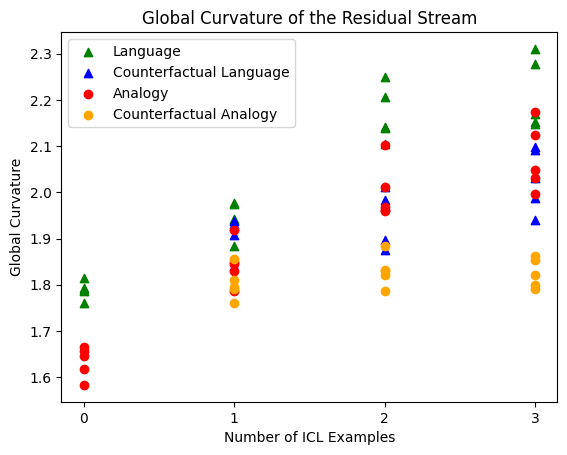

In [124]:
curve_lang0 = dataset_curvatures[0]
curve_lang1 = dataset_curvatures[1]
curve_lang2 = dataset_curvatures[2]
curve_lang3 = dataset_curvatures[3]

curve_c_lang1 = dataset_curvatures[4]
curve_c_lang2 = dataset_curvatures[5]
curve_c_lang3 = dataset_curvatures[6]

curve_an0 = dataset_curvatures[7]
curve_an1 = dataset_curvatures[8]
curve_an2 = dataset_curvatures[9]
curve_an3 = dataset_curvatures[10]

curve_c_an1 = dataset_curvatures[11]
curve_c_an2 = dataset_curvatures[12]
curve_c_an3 = dataset_curvatures[13]

x = [0] * len(curve_lang0) + [1] * len(curve_lang1) + [2] * len(curve_lang2) + [3] * len(curve_lang3)
x_counter = x[len(curve_lang0):]

plt.scatter(x, curve_lang0 + curve_lang1 + curve_lang2 + curve_lang3, c="green", marker="^", label="Language")
plt.scatter(x_counter, curve_c_lang1 + curve_c_lang2 + curve_c_lang3, c="blue", marker="^", label="Counterfactual Language")

plt.scatter(x, curve_an0 + curve_an1 + curve_an2 + curve_an3, c="red", marker="o", label="Analogy")
plt.scatter(x_counter, curve_c_an1 + curve_c_an2 + curve_c_an3, c="orange", marker="o", label="Counterfactual Analogy")

plt.legend()
plt.title("Global Curvature of the Residual Stream")
plt.ylabel("Global Curvature")
plt.xlabel("Number of ICL Examples")
plt.xticks([0, 1, 2, 3])
plt.show()

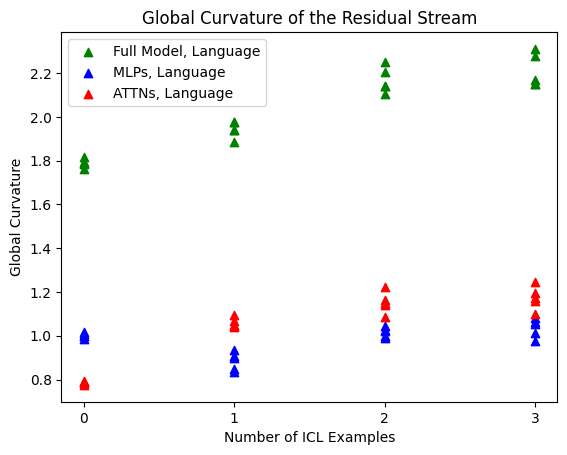

In [125]:
curve_lang0 = dataset_curvatures[0]
curve_lang1 = dataset_curvatures[1]
curve_lang2 = dataset_curvatures[2]
curve_lang3 = dataset_curvatures[3]

plt.scatter(x, curve_lang0 + curve_lang1 + curve_lang2 + curve_lang3, c="green", marker="^", label="Full Model, Language")

curve_lang0 = dataset_mlp_curvatures[0]
curve_lang1 = dataset_mlp_curvatures[1]
curve_lang2 = dataset_mlp_curvatures[2]
curve_lang3 = dataset_mlp_curvatures[3]

plt.scatter(x, curve_lang0 + curve_lang1 + curve_lang2 + curve_lang3, c="blue", marker="^", label="MLPs, Language")

curve_lang0 = dataset_attn_curvatures[0]
curve_lang1 = dataset_attn_curvatures[1]
curve_lang2 = dataset_attn_curvatures[2]
curve_lang3 = dataset_attn_curvatures[3]

plt.scatter(x, curve_lang0 + curve_lang1 + curve_lang2 + curve_lang3, c="red", marker="^", label="ATTNs, Language")

plt.legend()
plt.title("Global Curvature of the Residual Stream")
plt.ylabel("Global Curvature")
plt.xlabel("Number of ICL Examples")
plt.xticks([0, 1, 2, 3])
plt.show()

# Random Repeats

### Curvature Functions

In [13]:
import numpy as np
import random 

def generate_random_token_sequence(seq_length, tokenizer):
  valid_token_ids = [i for i in range(tokenizer.vocab_size) if i != tokenizer.pad_token_id]
  random_token_ids = random.choices(valid_token_ids, k=seq_length)
  random_tokens = tokenizer.convert_ids_to_tokens(random_token_ids)
  random_sequence = tokenizer.convert_tokens_to_string(random_tokens)
  return random_token_ids, random_sequence
    
def repeats(i, text = 'sky mug free purple silly'):
    s =" "
    for j in range(max(1, i)):
        s+=text+' '
    return ' '+s.strip()

def randseq(i, text = 'sky mug free purple silly'):
  words = text.split(" ")
  num_samps = len(words)
  s = " "
  for j in range(max(1, i)):
    s+= " ".join(np.random.choice(words, num_samps)) + " "
  return ' '+s.strip()

num_reps = 150
data = repeats(num_reps, 'a b c d')

In [14]:
tokenizer = AutoTokenizer.from_pretrained("gpt2", device=device)

In [45]:
def compute_global_curvature_nonrepeating(cache, total_layers, stream_idx, include_mlps=True, include_attn=True):
  displacement = torch.sqrt(torch.sum(torch.square(cache["resid_post", total_layers - 1][stream_idx] - cache["resid_pre", 0][stream_idx])))
  distance = 0.0
  for layer in range(total_layers):
    if include_mlps:
      distance+=torch.linalg.norm(cache['mlp_out', layer][stream_idx])
    if include_attn:
      distance+=torch.linalg.norm(cache['attn_out', layer][stream_idx])
  return (distance/displacement).cpu().numpy()
    
def early_decode(model, cache, layer, mid=False):
  return model.unembed(cache[f'blocks.{layer}.hook_resid_{"mid" if mid else "post"}'].unsqueeze(0))
    
def compute_global_curvature(cache, total_layers, stream_idx, sequence_length, include_mlps=True, include_attn=True):
  curvatures = []
  for str_idx in range(stream_idx, len(cache["resid_pre", 0]), sequence_length):
    if include_mlps and include_attn:
      displacement = torch.sqrt(torch.sum(torch.square(cache["resid_post", total_layers - 1][str_idx] - cache["resid_pre", 0][str_idx])))
    elif include_mlps:
      displacement = torch.sqrt(torch.sum(torch.square(cache["resid_post", total_layers - 1][str_idx] - cache["resid_mid", 0][str_idx])))
    elif include_attn:
      displacement = torch.sqrt(torch.sum(torch.square(cache["resid_mid", total_layers - 1][str_idx] - cache["resid_pre", 0][str_idx])))
    else:
      raise ValueError("Must include either MLPs or attention in the curvature calculation.")
    print(f'displacement, {displacement}')
    distance = 0.0
    for layer in range(total_layers):
      if include_mlps:
        distance+=torch.linalg.norm(cache['mlp_out', layer][str_idx])
      if include_attn:
        distance+=torch.linalg.norm(cache['attn_out', layer][str_idx])
    print(distance)
    curvatures.append((distance/displacement).cpu().numpy())
  return curvatures


def layer_wise_curvature(cache, total_layers, stream_idx, sequence_length, include_mlps=True, include_attn=True, cumulative=False):
  curvatures = []
  for str_idx in range(stream_idx, len(cache["resid_pre", 0]), sequence_length):
    if include_mlps and include_attn:
      displacement = torch.sqrt(torch.sum(torch.square(cache["resid_post", total_layers - 1][str_idx] - cache["resid_pre", 0][str_idx])))
    elif include_mlps:
      displacement = torch.sqrt(torch.sum(torch.square(cache["resid_post", total_layers - 1][str_idx] - cache["resid_mid", 0][str_idx])))
    elif include_attn:
      displacement = torch.sqrt(torch.sum(torch.square(cache["resid_mid", total_layers - 1][str_idx] - cache["resid_pre", 0][str_idx])))
    else:
      raise ValueError("Must include either MLPs or attention in the curvature calculation.")
    
    dict_distance = {}
    if cumulative:
        distance = 0.0
    for layer in range(total_layers):
      if not cumulative:
          distance = 0.0
    
      if include_mlps:
        distance+=torch.linalg.norm(cache['mlp_out', layer][str_idx])
      if include_attn:
        distance+=torch.linalg.norm(cache['attn_out', layer][str_idx])
      dict_distance[layer] = (distance/displacement).clone().detach().item()
    dict_distance['total'] = sum(dict_distance.values())
    curvatures.append(dict_distance)
  return curvatures

In [46]:
from tqdm import tqdm

def repeated_sequence_analysis(string, num_repeats, model, global_c=False):
  data = repeats(num_repeats, string)

  gpt2_tokens = model.to_tokens(data)[0]
  seq_length = int(len(gpt2_tokens[1:])/num_repeats) # Get rid of start token

  dataset_early_decoding_probs = {}
  dataset_early_decoding_rrs = {}
  gpt2_logits, gpt2_cache = model.run_with_cache(gpt2_tokens, remove_batch_dim=True)
  loss = model.loss_fn(gpt2_logits, gpt2_tokens.unsqueeze(0), per_token=True)[0].cpu()

  results = {}

  for stream_index in tqdm(range(seq_length), desc="iterating through each token in sequence"):
    #print((stream_index + 1)/seq_length)
    losses = loss[stream_index::seq_length]
    logits = gpt2_logits[0, stream_index::seq_length, :].cpu()
    if global_c:
      dataset_curvatures = compute_global_curvature(gpt2_cache, model.cfg.n_layers, stream_index, seq_length)
    else:
      dataset_curvatures = layer_wise_curvature(gpt2_cache, model.cfg.n_layers, stream_index, seq_length)
    dataset_log_probs = torch.nn.functional.log_softmax(logits.cpu(), dim=-1)

    for layer in range(model.cfg.n_layers):
      decodes = early_decode(model, gpt2_cache, layer)
      softmax_logits = torch.nn.functional.log_softmax(decodes[0, stream_index::seq_length, :].cpu(), dim=-1)
      ed_correct_probs = softmax_logits[:, gpt2_tokens[stream_index + 1]]

      # Compute reciprocal ranks
      
      ed_reciprocal_ranks = []
      for i in range(len(ed_correct_probs)):
        vocab_probs, _ = torch.sort(softmax_logits[i], descending=True)
        rank = (vocab_probs == ed_correct_probs[i]).nonzero(as_tuple=True)[0][0]
        reciprocal_rank = 1/(rank + 1)
        ed_reciprocal_ranks.append(reciprocal_rank)

      dataset_early_decoding_probs[layer] = ed_correct_probs
      dataset_early_decoding_rrs[layer] = ed_reciprocal_ranks

    index_results = {
        "logits": logits,
        "losses": losses,
        "curvatures": dataset_curvatures,
        "log_probabilities": dataset_log_probs,
        "ed_log_probabilities": dataset_early_decoding_probs,
        "ed_reciprocal_ranks": dataset_early_decoding_rrs
    }
    results[stream_index] = index_results

  return results


### Plotting Fxns

In [61]:
def plot_curvature_vs_repetitions(results, sequence_position, offset=0):
  x = list(range(len(results[sequence_position]["curvatures"])))
  y = results[sequence_position]["curvatures"]
  plt.scatter(x[offset:], y[offset:], c="green", marker="^")
  plt.legend()
  plt.title("Global Curvature of the Residual Stream")
  plt.ylabel("Global Curvature")
  plt.xlabel("Repetitions")
  plt.show()

def plot_earliest_1_rr_vs_repetitions(results, sequence_position, offset=0):
  rr_dict = results[sequence_position]["ed_reciprocal_ranks"]
  x = list(range(len(rr_dict[0])))
  earliest_rr_of_1 = []
  for i in range(len(x)):
    early_rr = 12 # default value if no rr of 1
    for layer in range(len(rr_dict)):
      if rr_dict[layer][i] == 1:
        early_rr = layer
        break
    earliest_rr_of_1.append(early_rr)
  y = earliest_rr_of_1
  plt.scatter(x[offset:], y[offset:], c="green", marker="^")
  plt.legend()
  plt.title("Earliest RR of 1 Layer vs Repetitions")
  plt.ylabel("Layer")
  plt.xlabel("Repetitions")
  plt.show()

def plot_rr_vs_repetitions(results, sequence_position, offset=0, layer=11):
  rr_dict = results[sequence_position]["ed_reciprocal_ranks"]
  x = list(range(len(rr_dict[layer])))
  y = rr_dict[layer]
  plt.scatter(x[offset:], y[offset:], c="green", marker="^")
  plt.legend()
  plt.title(f"RR of Layer {layer} vs Repetitions")
  plt.ylabel("RR")
  plt.xlabel("Repetitions")
  plt.show()

def plot_loss_vs_repetitions(results, sequence_position, offset=0):
  x = list(range(len(results[sequence_position]["losses"])))
  y = results[sequence_position]["losses"]
  plt.scatter(x[offset:], y[offset:], c="green", marker="^")
  plt.legend()
  plt.title("Loss vs Repetitions")
  plt.ylabel("Loss")
  plt.xlabel("Repetitions")
  plt.show()

def plot_curvature_loss_vs_repetitions(results, sequence_position, offset=0,
                                        show=True, save_fig=False, save_path=None):
  x = list(range(len(results[sequence_position]["curvatures"])))
  curvatures = results[sequence_position]["curvatures"] 
  losses = results[sequence_position]["losses"]
  
  fig, ax1 = plt.subplots()
  ax1.scatter(x[offset:], curvatures[offset:], label='curvature', color='b')
  ax1.set_xlabel('Repetitions')
  ax1.set_ylabel('curvature', color='b')
  ax1.tick_params(axis='y', labelcolor='b')

  ax2 = ax1.twinx()

  ax2.scatter(x[offset:], losses[offset:], label='loss', color='r')
  ax2.set_ylabel('loss', color='r')
  ax2.tick_params(axis='y', labelcolor='r')

  lines1, labels1 = ax1.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  lines = lines1 + lines2
  labels = labels1 + labels2
  ax1.legend(lines, labels, loc='upper right')

  plt.title("Curvature and Loss vs Repetitions")
  if save_fig and save_path:
    plt.savefig(save_path)
  if show:
    plt.show()
  plt.close()

def plot_layer_curvature_loss_vs_repetitions(results, sequence_position, layer, offset=0,
                                        show=True, save_fig=False, save_path=None):
  x = list(range(len(results[sequence_position]["curvatures"])))
  curvatures = results[sequence_position]["curvatures"] 
  losses = results[sequence_position]["losses"]
  
  fig, ax1 = plt.subplots()
  ax1.scatter(x[offset:], [curv[layer] for curv in curvatures[offset:]], label=f'curvature_layer_{layer}', color='b')
  ax1.set_xlabel('Repetitions')
  ax1.set_ylabel(f'layer {layer} curvature', color='b')
  ax1.tick_params(axis='y', labelcolor='b')

  ax2 = ax1.twinx()

  ax2.scatter(x[offset:], losses[offset:], label='loss', color='r')
  ax2.set_ylabel('loss', color='r')
  ax2.tick_params(axis='y', labelcolor='r')
    
  lines1, labels1 = ax1.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
    
  lines =  lines1 + lines2
  labels =  labels1 + labels2
  ax1.legend(lines, labels, loc='upper right')

  plt.title("Curvature and Loss vs Repetitions")
  if save_fig and save_path:
    plt.savefig(save_path)
  if show:
    plt.show()
  plt.close()

def plot_curvature_layers(results, sequence_position, repetition, show=True, save_fig=False, save_path=None):
  NUM_LAYERS = 12
  curvatures = results[sequence_position]["curvatures"] 
  losses = results[sequence_position]["losses"]
  
  fig, ax1 = plt.subplots()
  x = list(range(NUM_LAYERS))
  ax1.scatter(x, [curvatures[repetition][layer_val] for layer_val in x], label=f'layerwise_curvature_reptition={repetition}', color='b')
  ax1.set_xlabel('Layer')
  ax1.set_ylabel(f'layer curvature for repetition {repetition}', color='b')
  ax1.tick_params(axis='y', labelcolor='b')

  lines, labels = ax1.get_legend_handles_labels()
    
  plt.title(f"Layer Curvature for Repetition {repetition}")
  if save_fig and save_path:
    plt.savefig(save_path)
  if show:
    plt.show()
  plt.close()

### Curvature Example

In [93]:
random_tokens = generate_random_token_sequence(4, tokenizer)

In [48]:
results = repeated_sequence_analysis("a b c d", 100, model, global_c=False)

iterating through each token in sequence: 100%|███████████████████████████████████████████████████████████████████████████████| 4/4 [00:36<00:00,  9.22s/it]


In [94]:
results1 = repeated_sequence_analysis(random_tokens[1], 100, model, global_c=False)

iterating through each token in sequence: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:33<00:00,  8.36s/it]


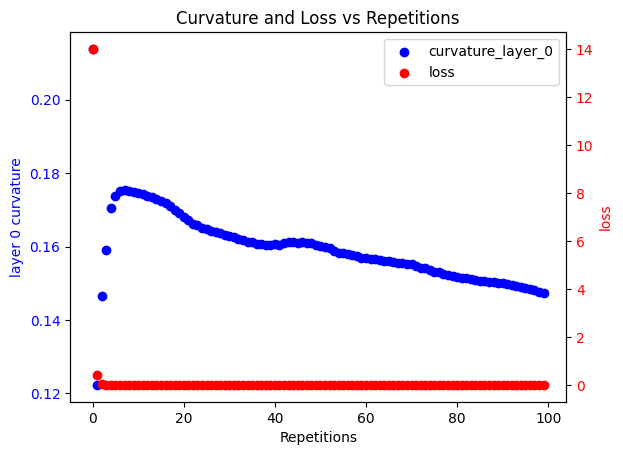

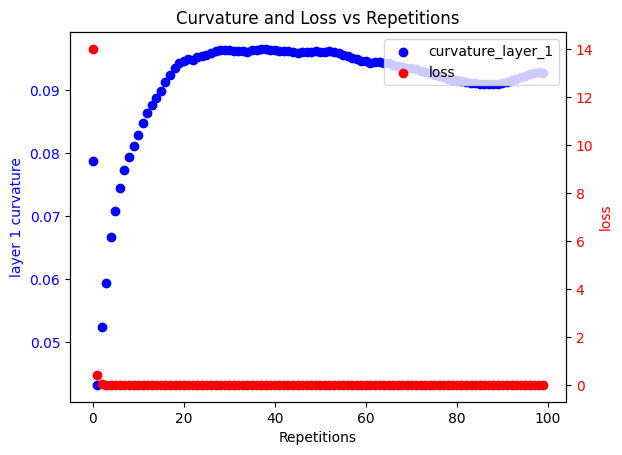

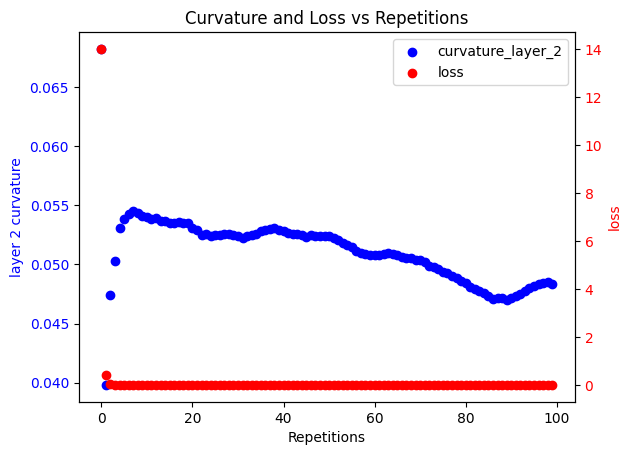

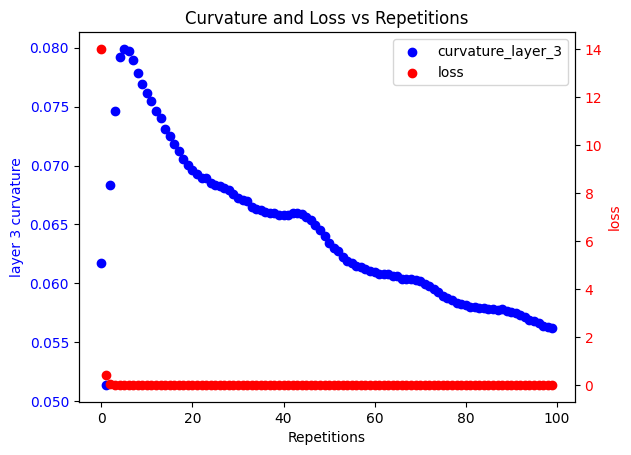

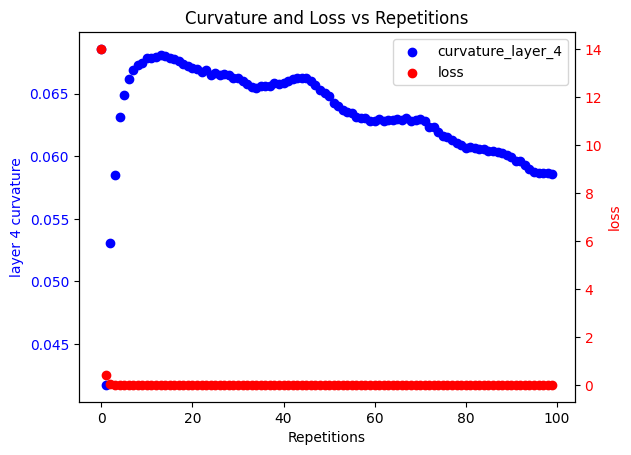

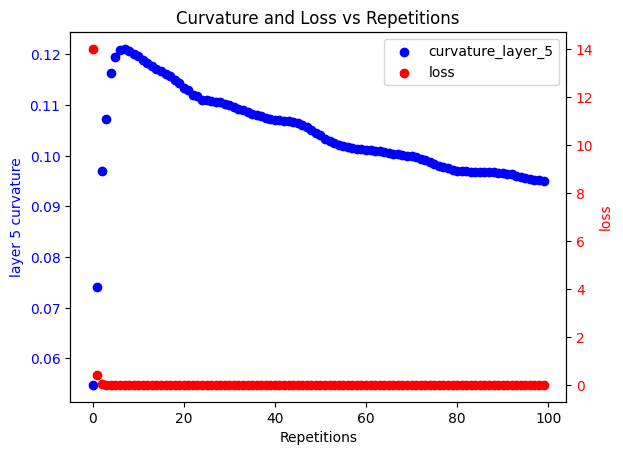

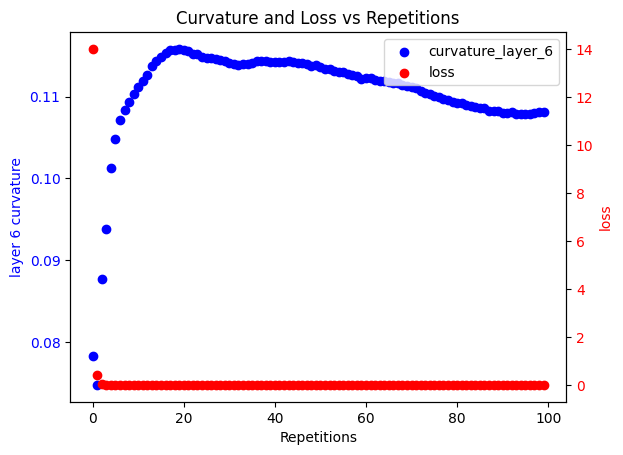

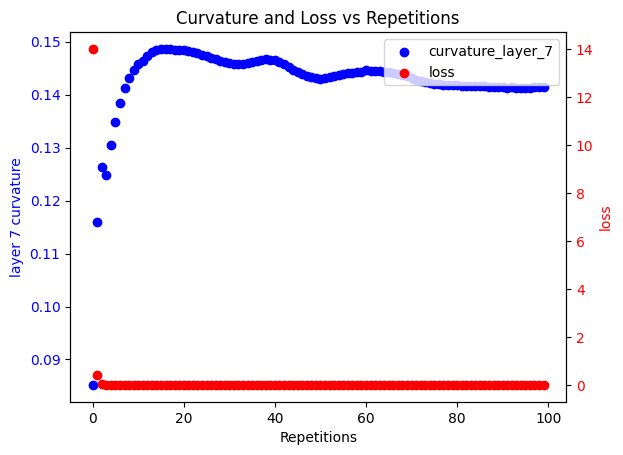

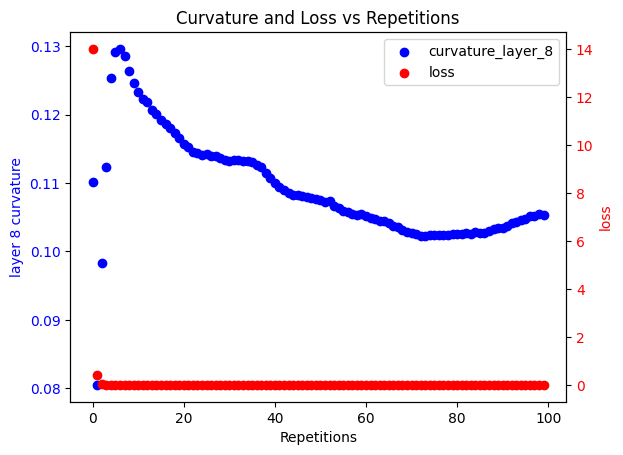

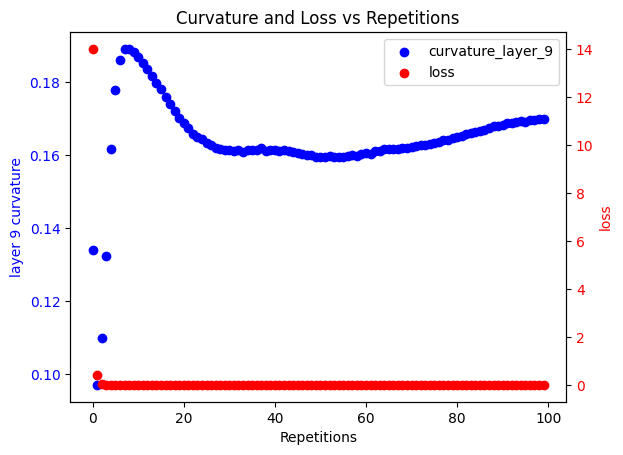

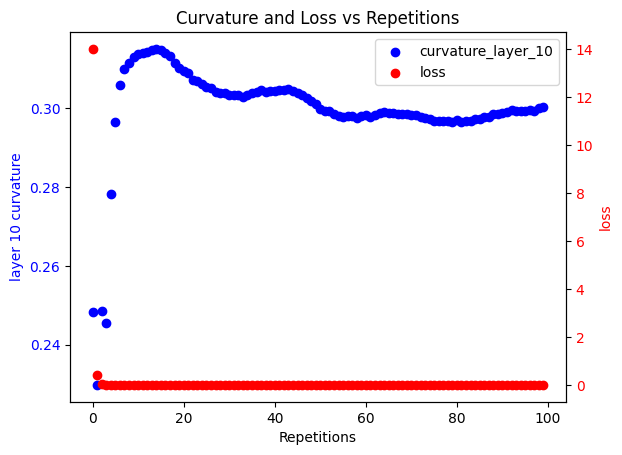

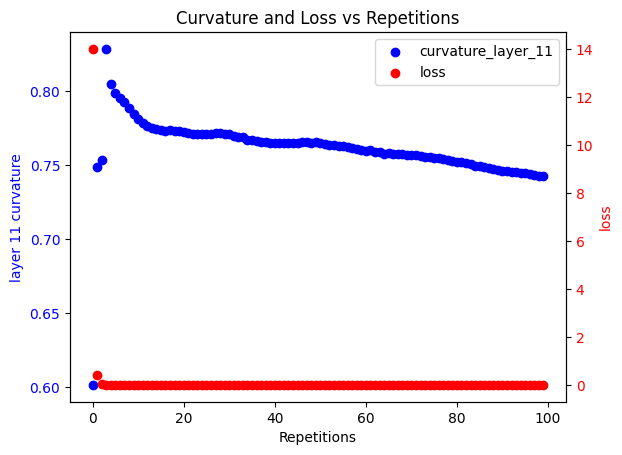

In [103]:
for i in range(12):
    plot_layer_curvature_loss_vs_repetitions(results1, 3, i, offset=0)

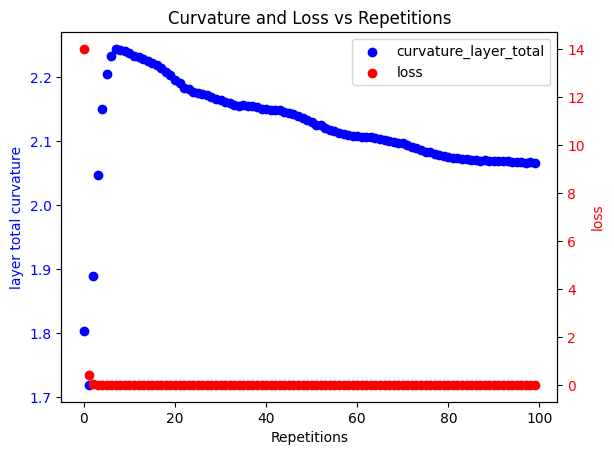

In [104]:
plot_layer_curvature_loss_vs_repetitions(results1, 3, 'total', offset=0)

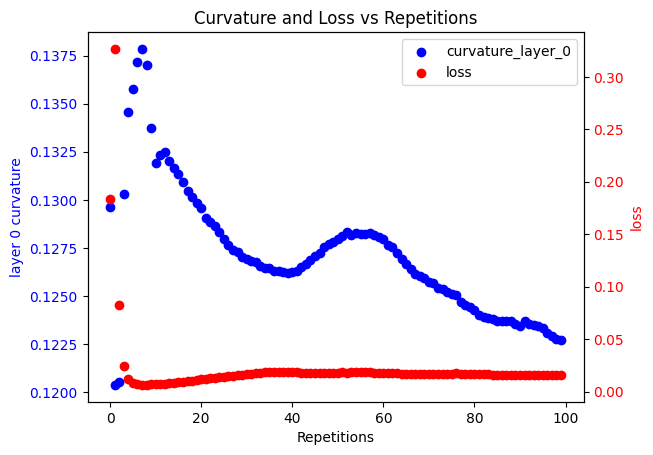

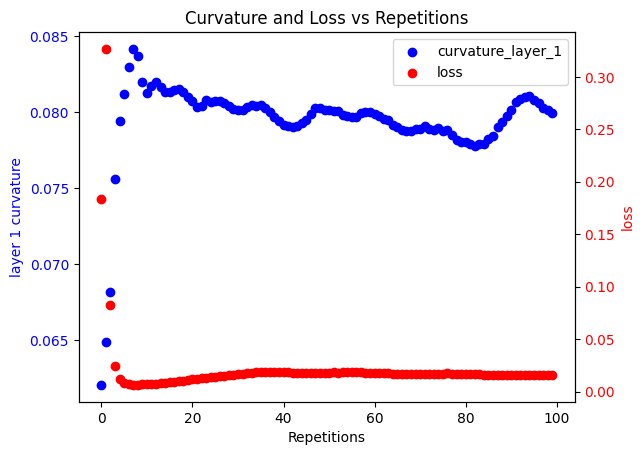

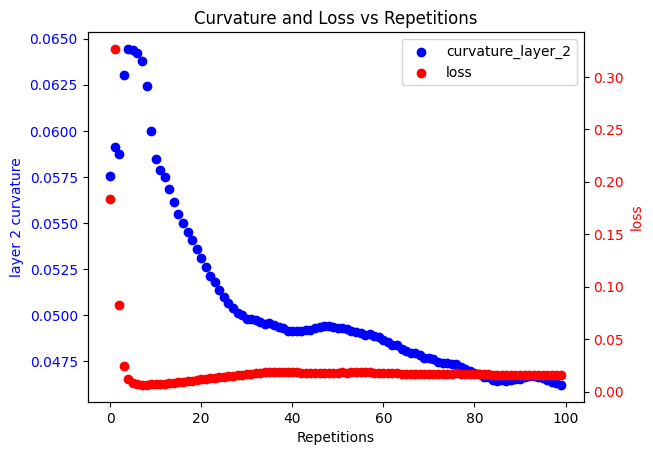

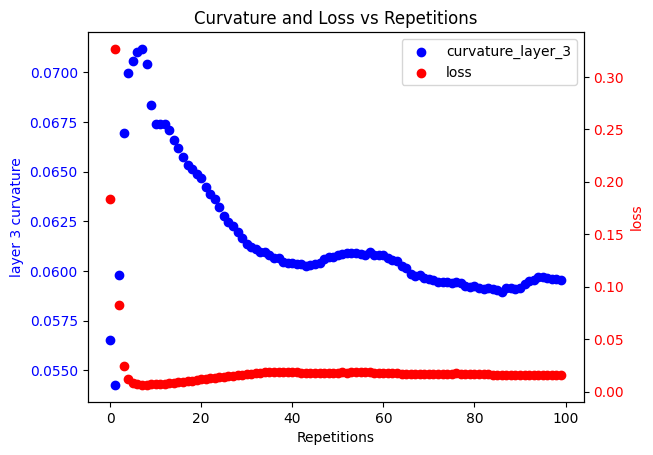

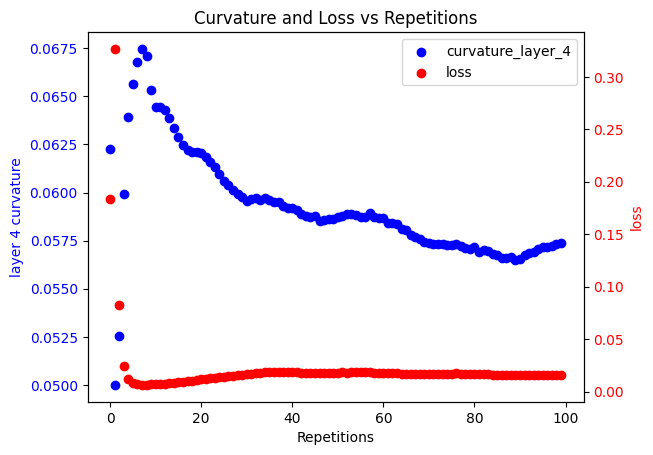

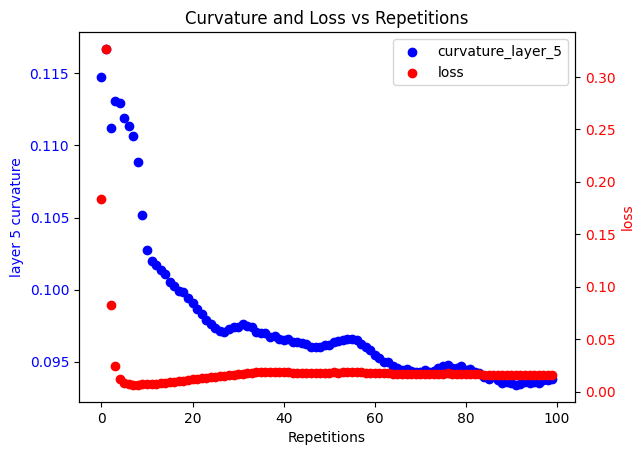

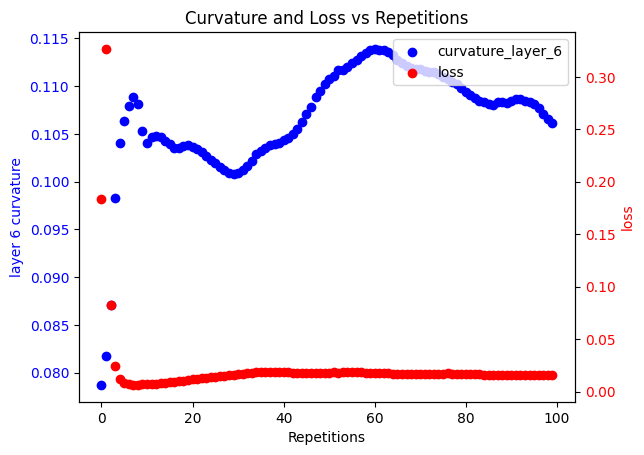

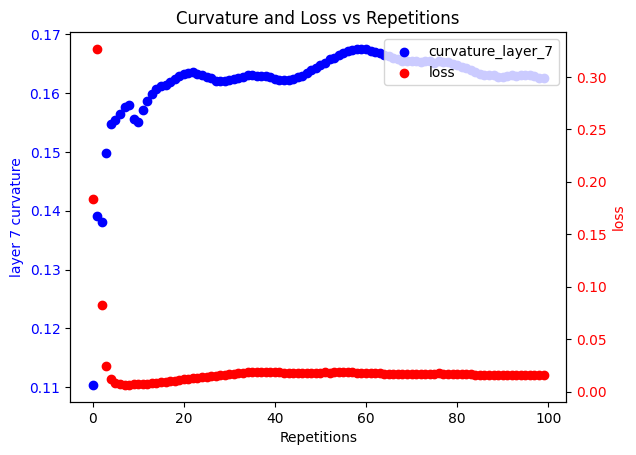

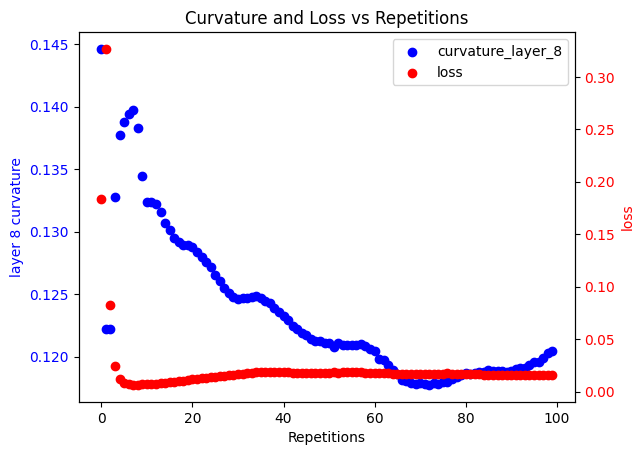

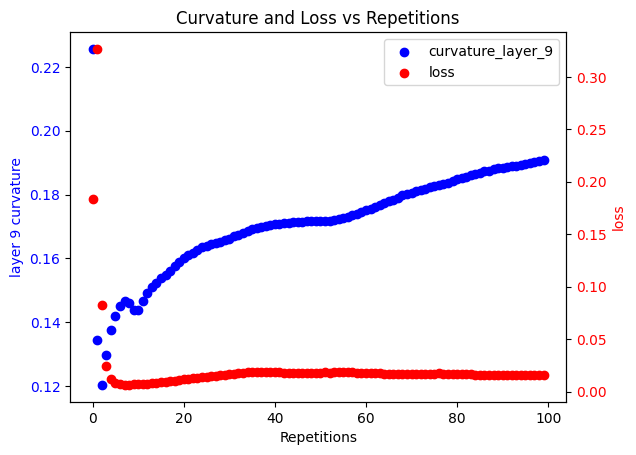

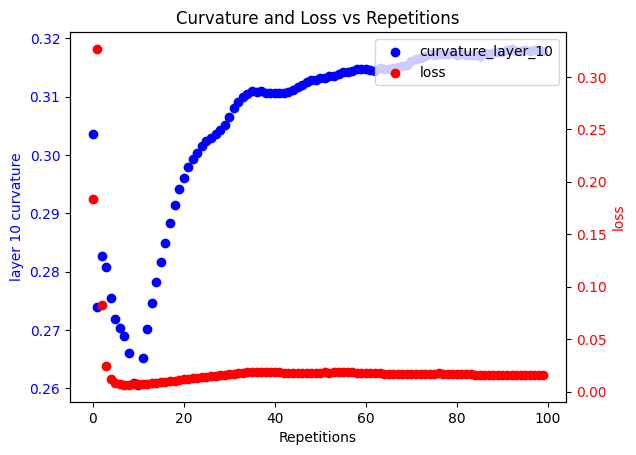

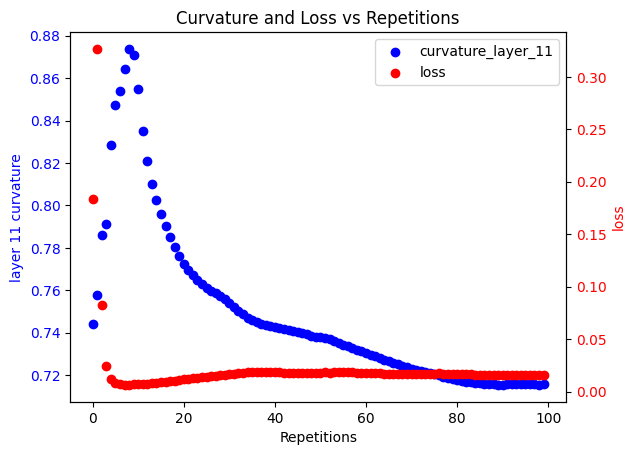

In [105]:
for i in range(12):
    plot_layer_curvature_loss_vs_repetitions(results, 3, i, offset=0)

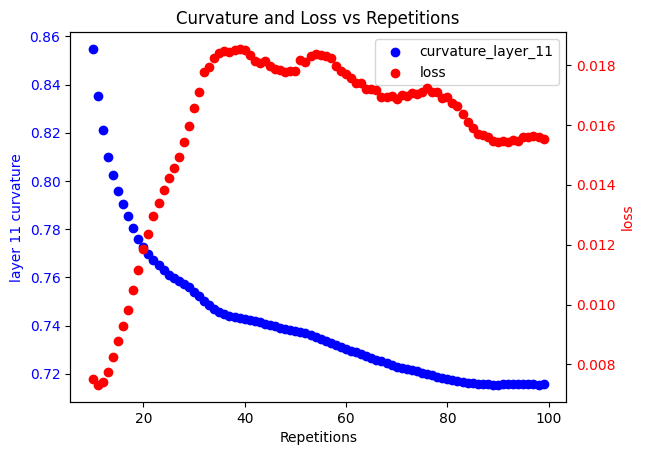

In [85]:
plot_layer_curvature_loss_vs_repetitions(results, 3, 11, offset=10)

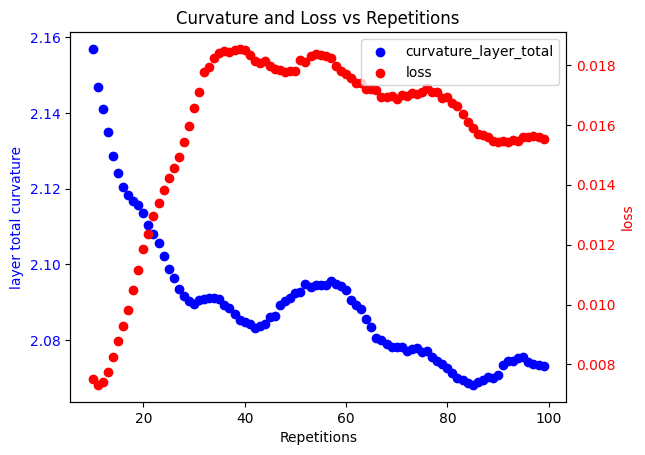

In [50]:
plot_layer_curvature_loss_vs_repetitions(results, 3, 'total', offset=10)

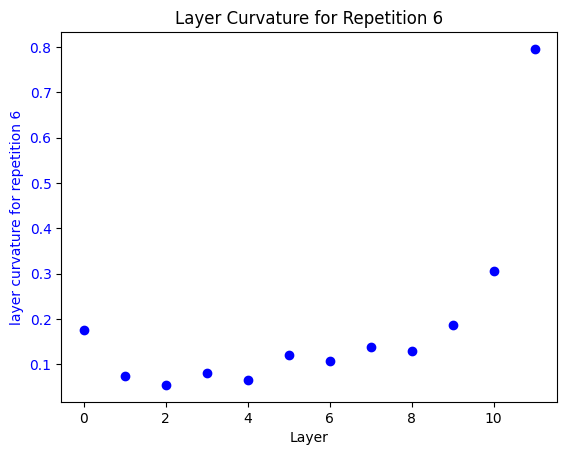

In [118]:
plot_curvature_layers(results1, 3, 6)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


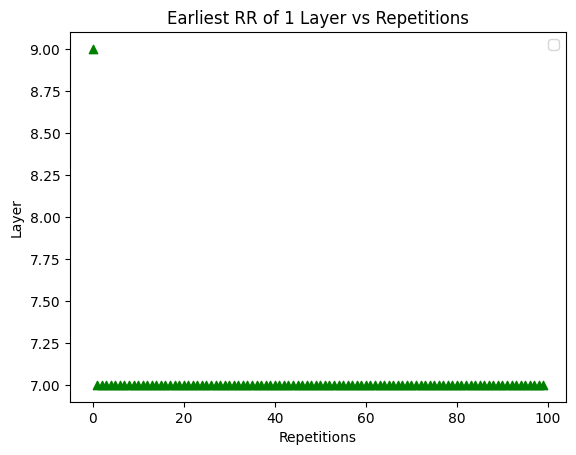

In [21]:
plot_earliest_1_rr_vs_repetitions(results, 3, offset=0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


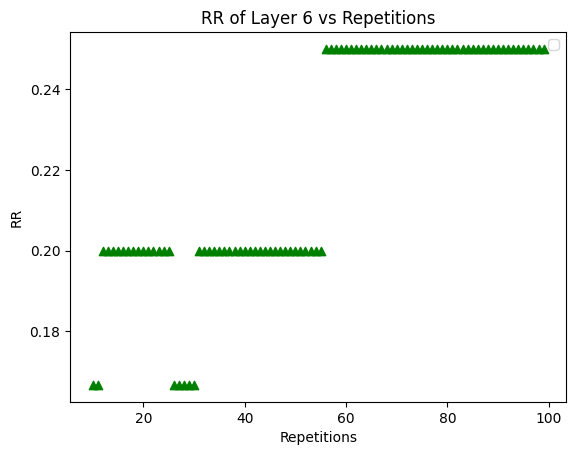

In [22]:
plot_rr_vs_repetitions(results, 3, offset=10, layer=6)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


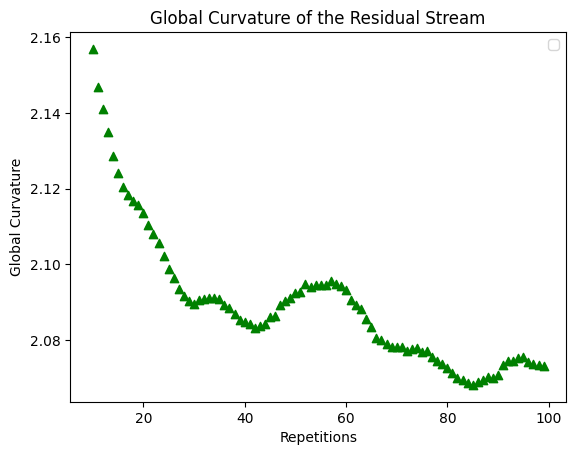

In [23]:
plot_curvature_vs_repetitions(results, 3, offset=10)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


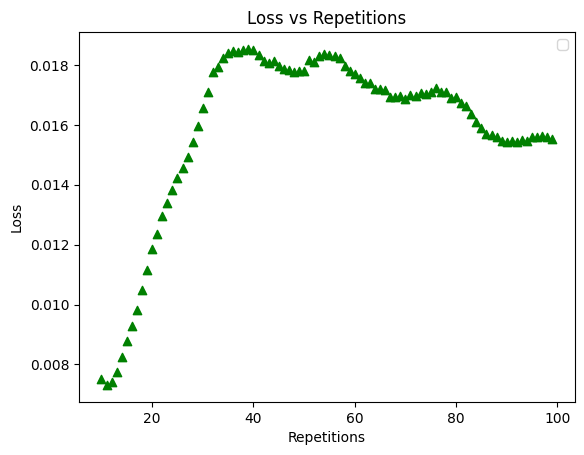

In [24]:
plot_loss_vs_repetitions(results, 3, offset=10)

In [135]:
## weed out cases where pattern, focus on non-synthetic task w pattern

Seq 0:  ostic fleet/*Rec


iterating through each token in sequence: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.68s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


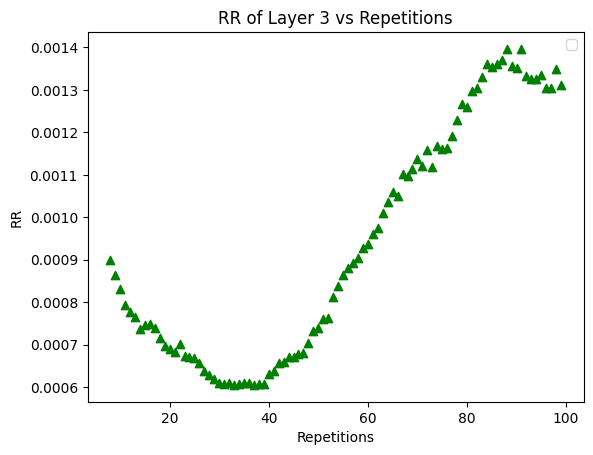

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


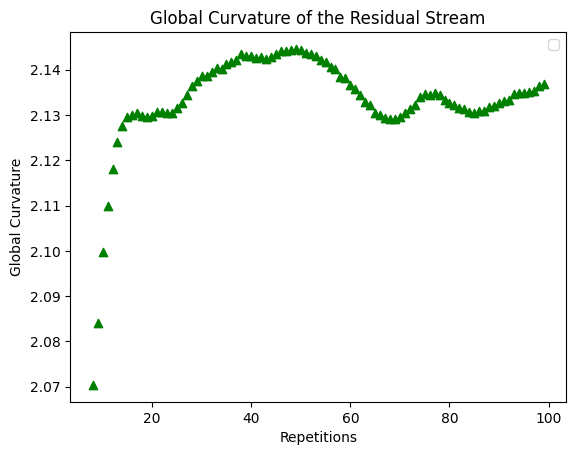

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


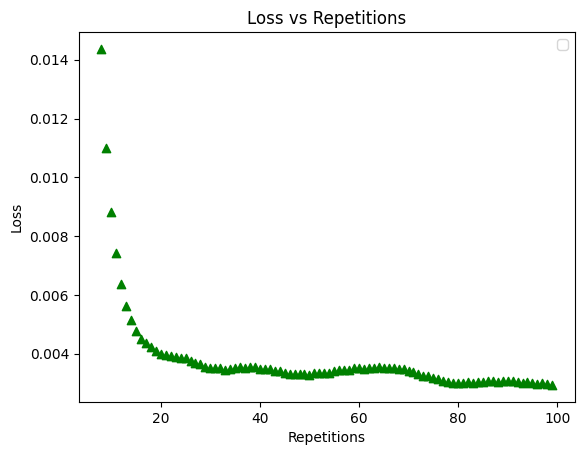

Seq 1:  INC Work Warriors Klux


iterating through each token in sequence: 100%|█████████████████████████████████████████████████████████████████████████| 4/4 [00:33<00:00,  8.43s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


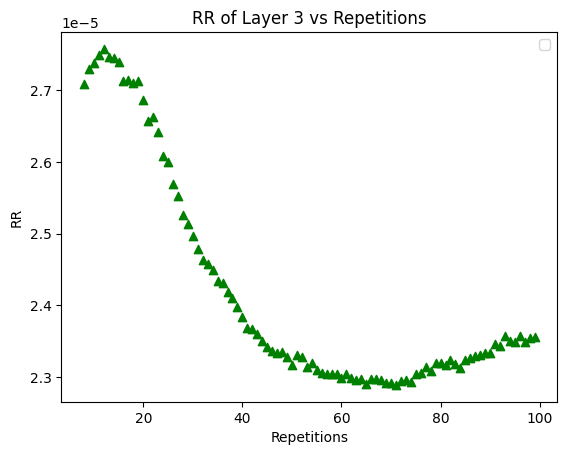

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


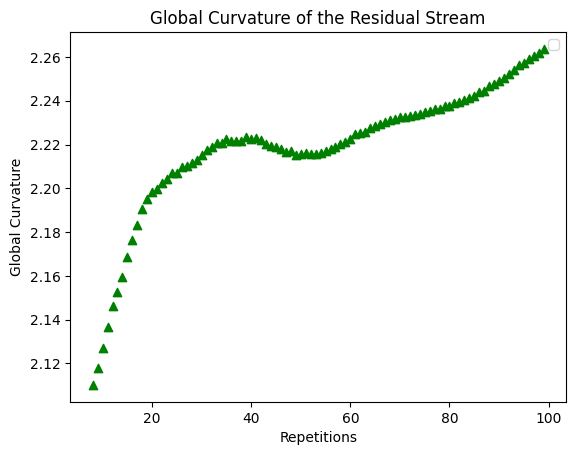

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


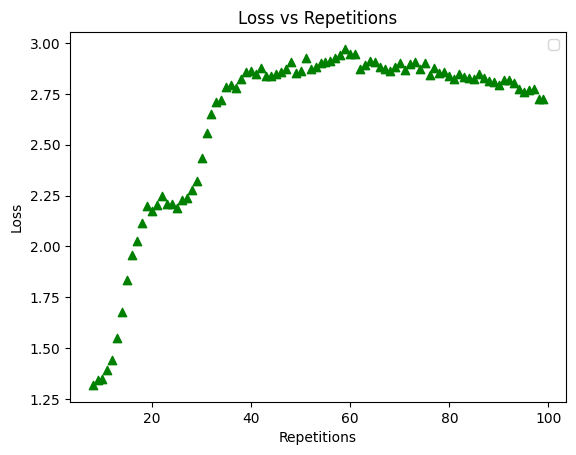

Seq 2:   keen Leavoidimester


iterating through each token in sequence: 100%|█████████████████████████████████████████████████████████████████████████| 4/4 [00:43<00:00, 10.84s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


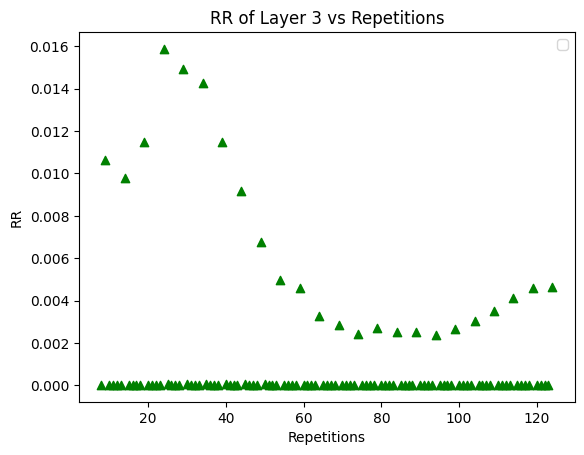

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


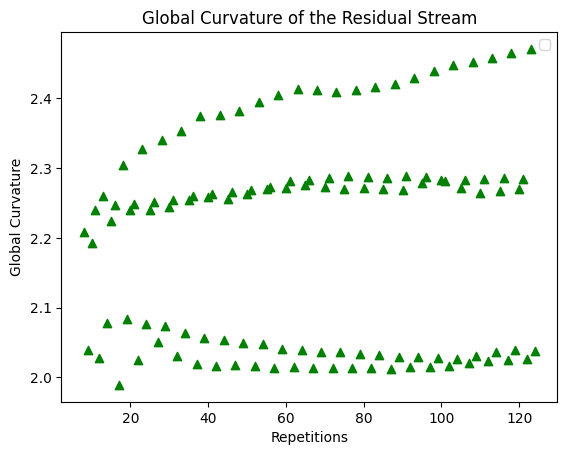

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


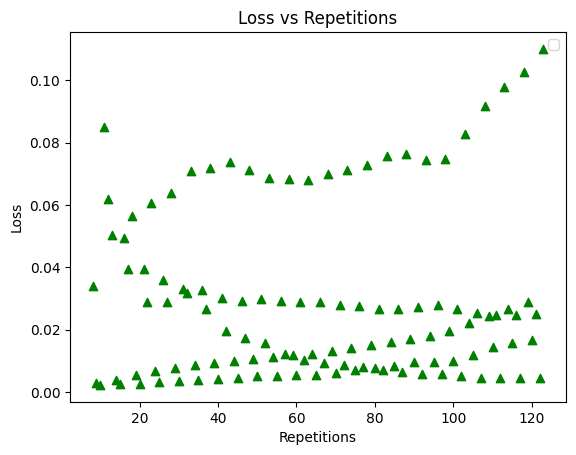

Seq 3:  ride Palestin***** sund


iterating through each token in sequence: 100%|█████████████████████████████████████████████████████████████████████████| 4/4 [00:35<00:00,  8.92s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


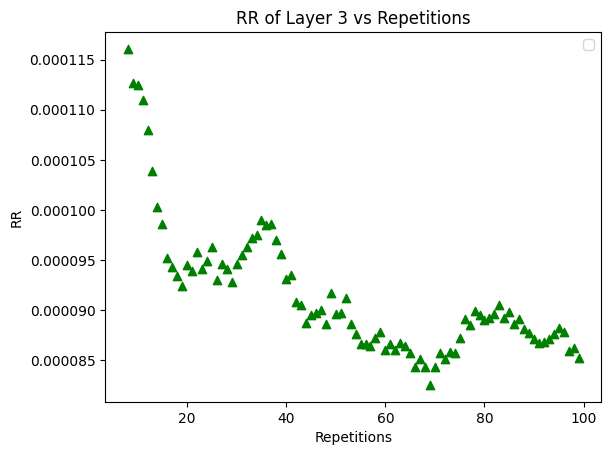

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


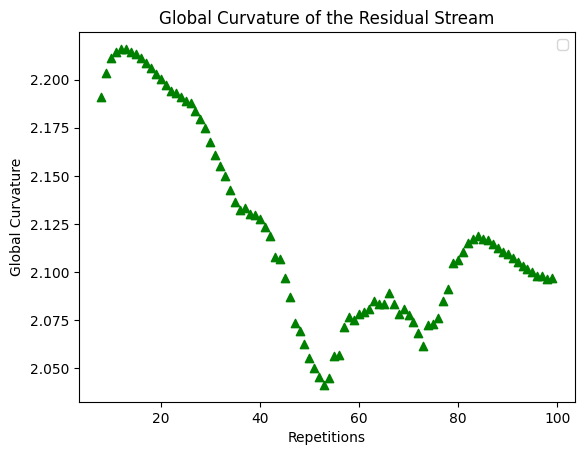

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


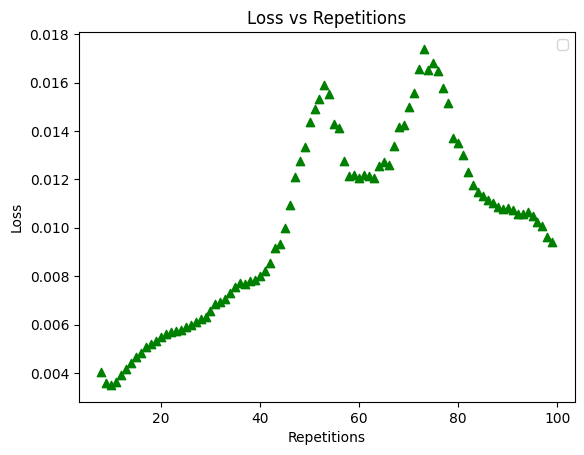

Seq 4:  onent DirtlitRod


iterating through each token in sequence: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.62s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


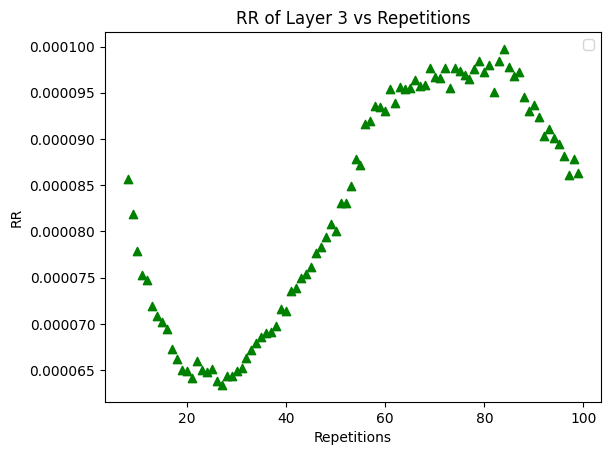

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


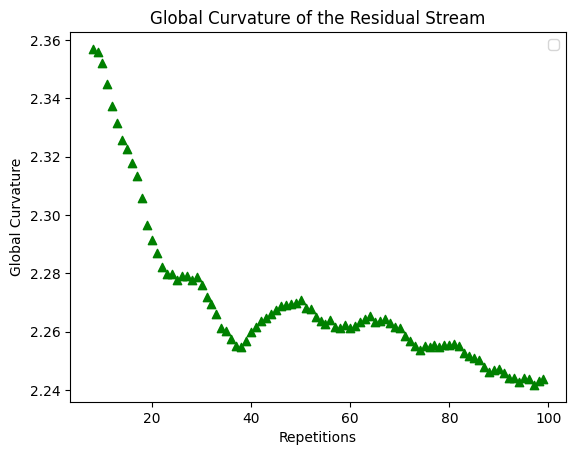

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


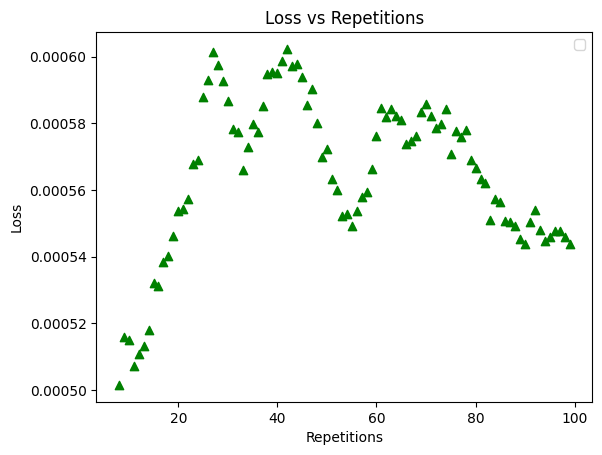

In [133]:
for i in range(5):
    seq_len = 4
    _, seq = generate_random_token_sequence(seq_len, tokenizer)
    print(f'Seq {i}', seq)
    results = repeated_sequence_analysis(seq, 100, model)
    plot_rr_vs_repetitions(results, 3, offset=seq_len*2, layer=3) ## why is layer 6 chosen specifically?
    plot_curvature_vs_repetitions(results, 3, offset=seq_len*2)
    plot_loss_vs_repetitions(results, 3, offset=seq_len*2)

Seq 0  healedflo"[ Nike thugs GHCundle2016 Bye Donkey


iterating through each token in sequence: 100%|█████████████████████████████████████████████████████████████| 10/10 [02:17<00:00, 13.79s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


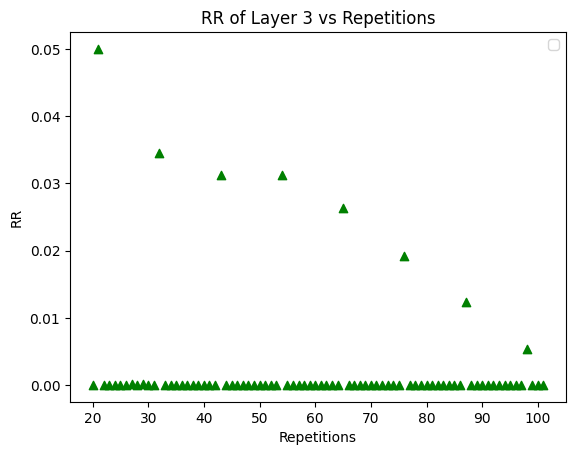

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


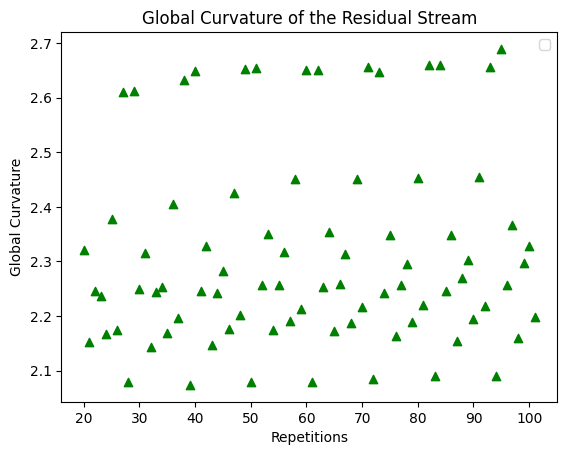

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


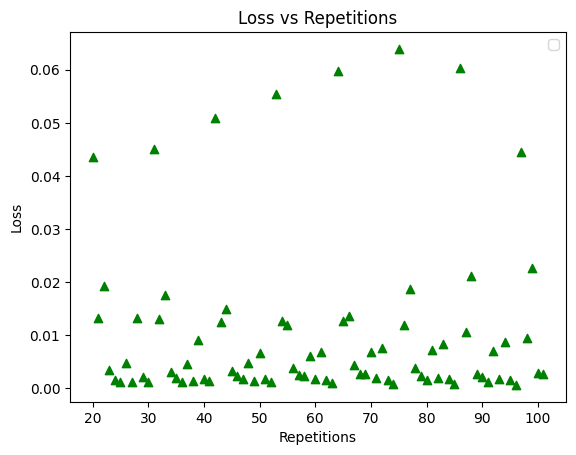

Seq 1  Harry En THR onset surrounds indicatingStaffozo Forbiddengoers


iterating through each token in sequence: 100%|█████████████████████████████████████████████████████████████| 10/10 [02:18<00:00, 13.86s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


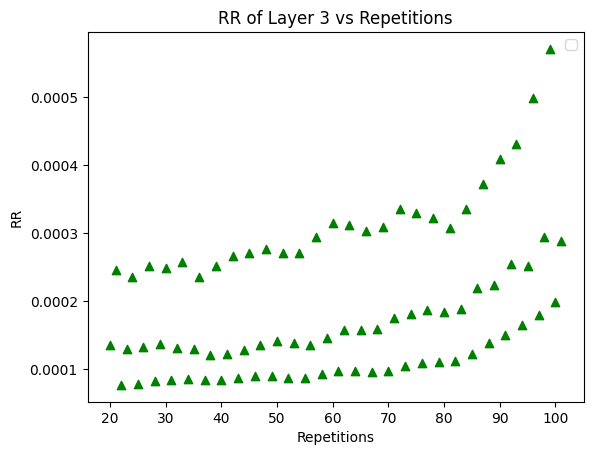

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


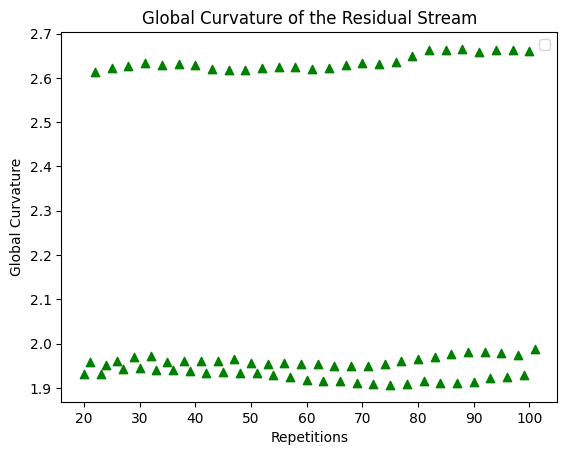

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


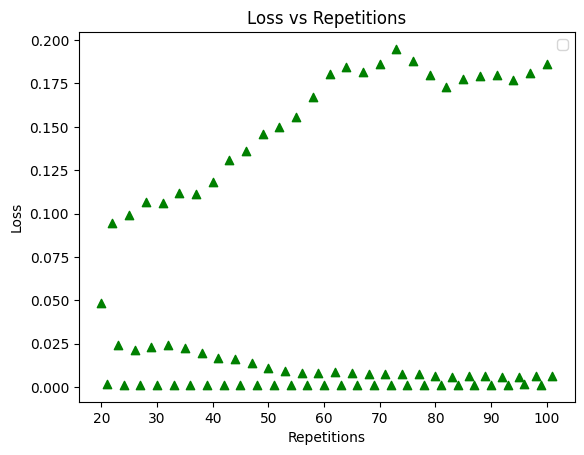

Seq 2 berries Citizens STATS icons wattSystemClearlysell murders taxes


iterating through each token in sequence: 100%|█████████████████████████████████████████████████████████████| 10/10 [02:16<00:00, 13.67s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


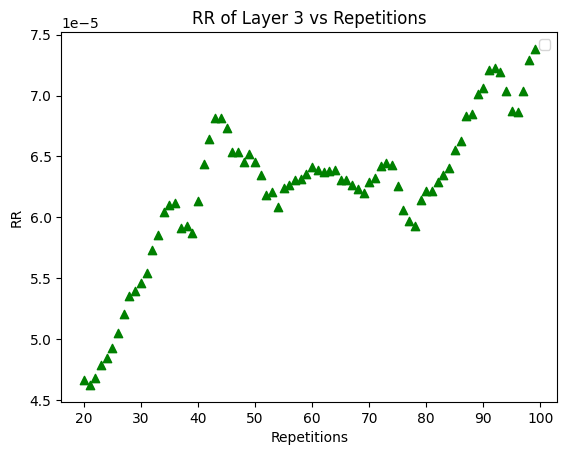

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


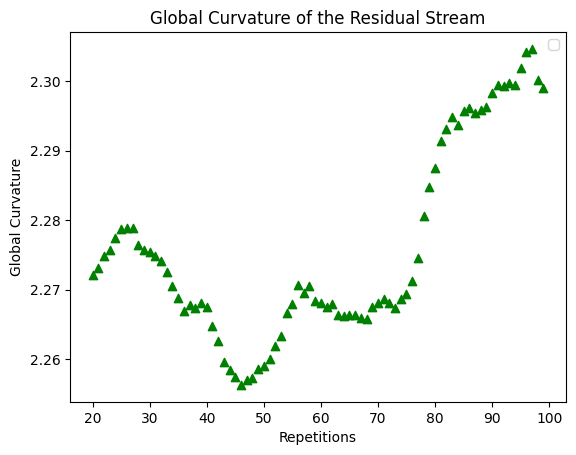

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


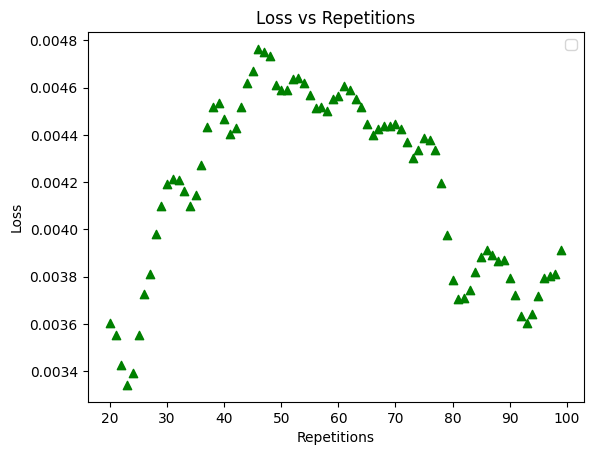

Seq 3 Jones rooft msg techno Leaving properlyipers163piration TIM


iterating through each token in sequence: 100%|█████████████████████████████████████████████████████████████| 10/10 [02:19<00:00, 13.92s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


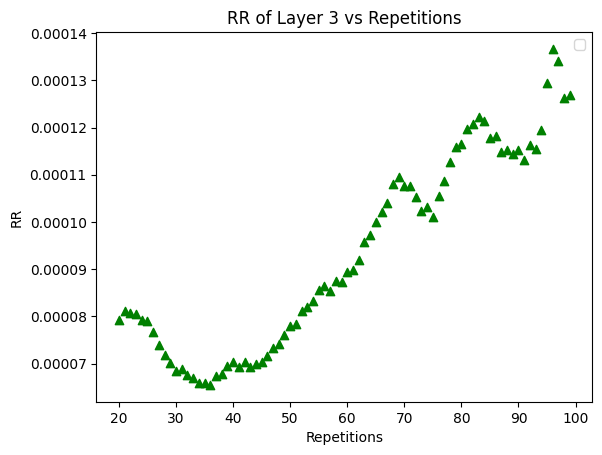

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


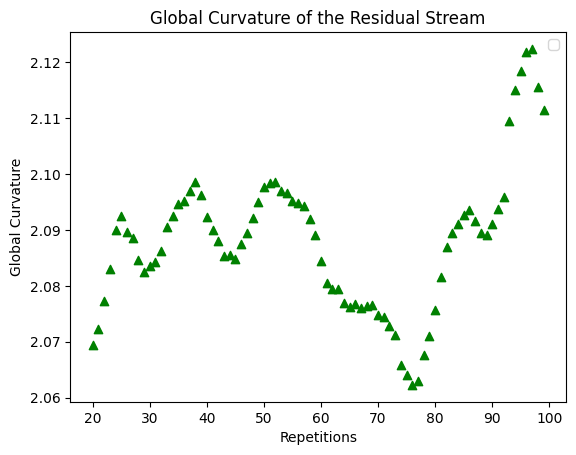

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


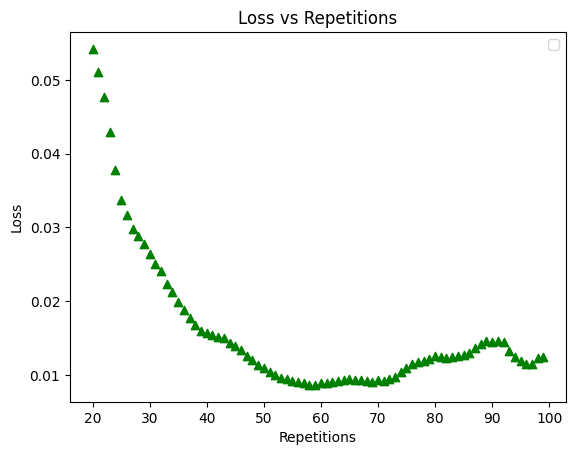

Seq 4  HELL legislators UFC Study Corridor indefurse ///omnia worries


iterating through each token in sequence: 100%|█████████████████████████████████████████████████████████████| 10/10 [02:15<00:00, 13.55s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


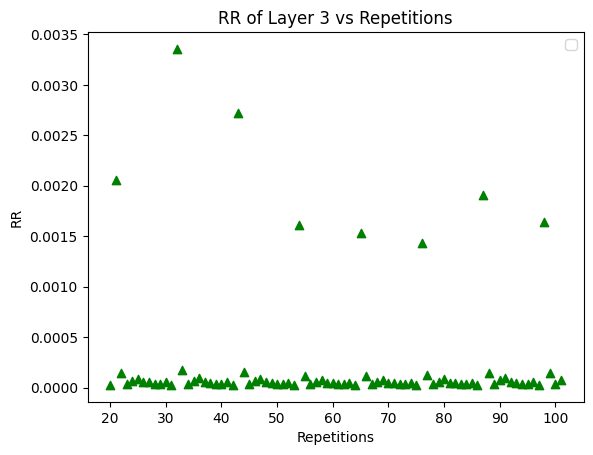

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


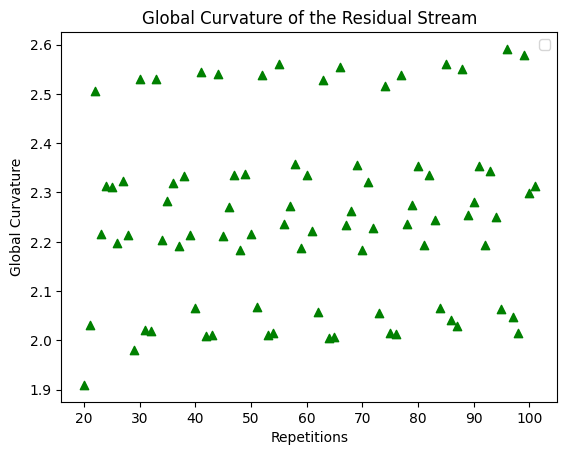

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


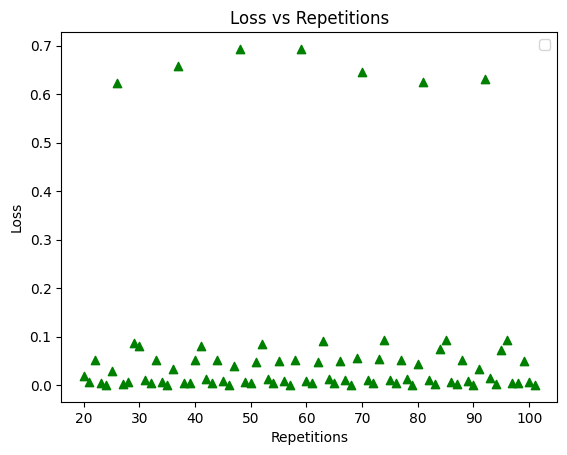

In [136]:
for i in range(5):
    seq_len = 10
    _, seq = generate_random_token_sequence(seq_len, tokenizer)
    print(f'Seq {i}', seq)
    results = repeated_sequence_analysis(seq, 100, model)
    plot_rr_vs_repetitions(results, 9, offset=seq_len*2, layer=3) ## why is layer 6 chosen specifically?
    plot_curvature_vs_repetitions(results, 9, offset=seq_len*2)
    plot_loss_vs_repetitions(results, 9, offset=seq_len*2)

In [71]:
results = repeated_sequence_analysis(seq, 100, model)

iterating through each token in sequence: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:42<00:00, 10.55s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


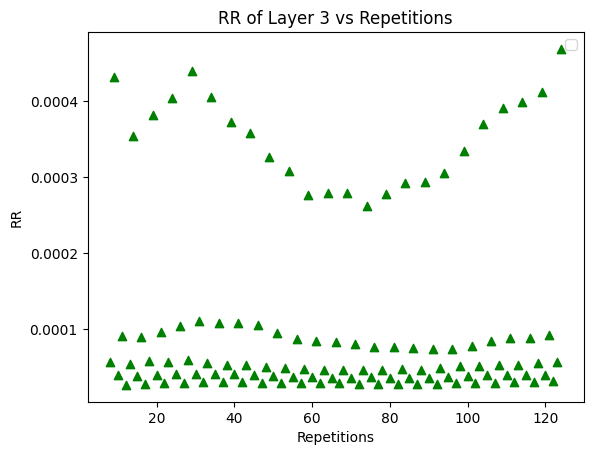

In [69]:
plot_rr_vs_repetitions(results, 3, offset=seq_len*2, layer=3) ## why is layer 6 chosen specifically?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


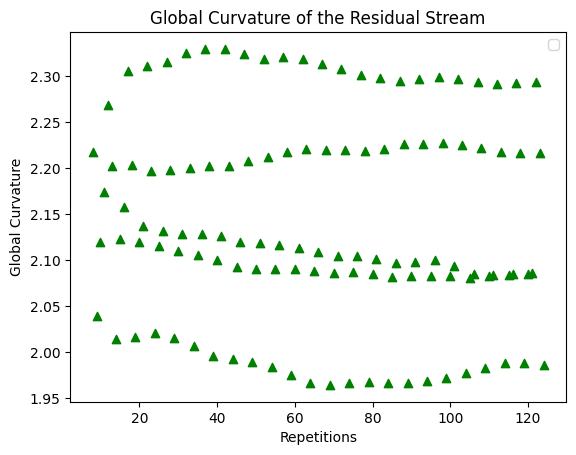

In [65]:
plot_curvature_vs_repetitions(results, 3, offset=seq_len*2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


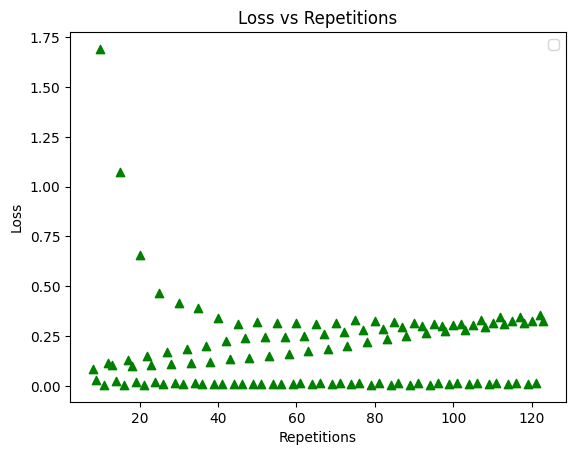

In [66]:
plot_loss_vs_repetitions(results, 3, offset=seq_len*2)

# Analysis Function

In [74]:
def word_transformation_analysis(data, model):

  gpt2_tokens = model.to_tokens(data)[0]
  dataset_early_decoding_probs = {}
  dataset_early_decoding_rrs = {}
  gpt2_logits, gpt2_cache = model.run_with_cache(gpt2_tokens, remove_batch_dim=True)
  loss = model.loss_fn(gpt2_logits, gpt2_tokens.unsqueeze(0), per_token=True)[0].cpu()

  results = {}

  losses = loss[2::4]
  logits = gpt2_logits[0, 2::4, :].cpu()
  dataset_curvatures = compute_global_curvature(gpt2_cache, model.cfg.n_layers, 2, 4)
  dataset_log_probs = torch.nn.functional.log_softmax(logits.cpu(), dim=-1)

  for layer in range(model.cfg.n_layers):
    decodes = early_decode(model, gpt2_cache, layer)
    softmax_logits = torch.nn.functional.log_softmax(decodes[0, 2::4, :].cpu(), dim=-1)
    ed_correct_probs = softmax_logits[:, gpt2_tokens[3::4].to("cpu")]
    ed_correct_probs = ed_correct_probs[torch.eye(ed_correct_probs.shape[0]).bool()]

    # Compute reciprocal ranks
    ed_reciprocal_ranks = []
    for i in range(len(ed_correct_probs)):
      vocab_probs, _ = torch.sort(softmax_logits[i], descending=True)
      rank = (vocab_probs == ed_correct_probs[i]).nonzero(as_tuple=True)[0][0]
      reciprocal_rank = 1/(rank + 1)
      #if reciprocal_rank != 1:
        #print(model.to_string(gpt2_tokens[3::3]))
      ed_reciprocal_ranks.append(reciprocal_rank)

    dataset_early_decoding_probs[layer] = ed_correct_probs
    dataset_early_decoding_rrs[layer] = ed_reciprocal_ranks

  results = {
      "logits": logits,
      "losses": losses,
      "curvatures": dataset_curvatures,
      "log_probabilities": dataset_log_probs,
      "ed_log_probabilities": dataset_early_decoding_probs,
      "ed_reciprocal_ranks": dataset_early_decoding_rrs
  }

  return results


# Copy Task

In [79]:
import json
data = json.load(open("datasets/past_tense_regular.json", "r"))

In [80]:
# Filter examples to only include one token inputs and targets
examples = []
for ex in data["examples"]:
  if len(model.to_tokens(" " + ex["input"])[0]) == 2:
    examples.append(ex)

In [81]:
len(examples)

1360

In [82]:
import random
random.seed(1)
random.shuffle(examples)

In [83]:
data = " "
for example in examples:
  data += example["input"] + " : " + example["input"] + "\n "
  if len(data.split(" ")) == 1020:
    break

In [100]:
results = word_transformation_analysis(data, model)

In [101]:
# Just for consistency with repeat results, to reuse plotting scripts
results_dict = {}
results_dict[0] = results

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


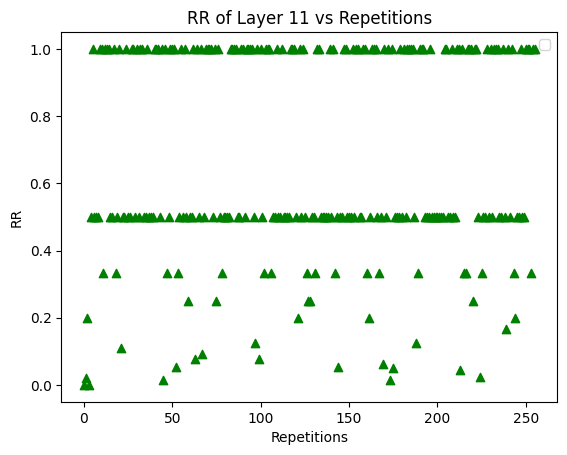

In [102]:
plot_rr_vs_repetitions(results_dict, 0, offset=0, layer=11)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


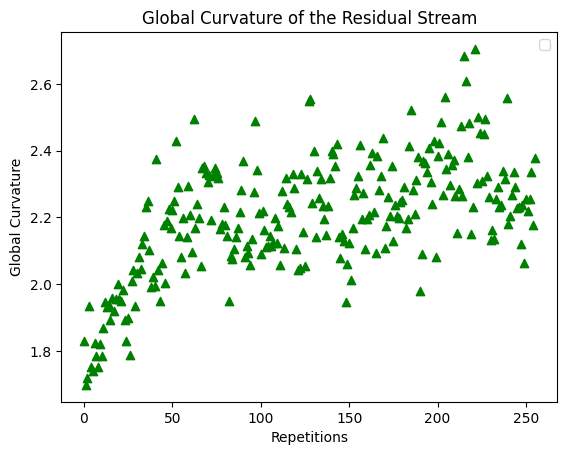

In [103]:
plot_curvature_vs_repetitions(results_dict, 0, offset=0)

# Past Tense Regular Analysis

In [89]:
import json
data = json.load(open("datasets/past_tense_regular.json", "r"))

In [90]:
# Filter examples to only include one token inputs and targets
examples = []
for ex in data["examples"]:
  if len(model.to_tokens(" " + ex["input"])[0]) == 2 and len(model.to_tokens(" " + ex["target"])[0]) == 2:
    examples.append(ex)

In [91]:
len(examples)

1144

In [92]:
import random
random.seed(1)
random.shuffle(examples)

In [93]:
data = " "
for example in examples:
  data += example["input"] + " : " + example["target"] + "\n "
  if len(data.split(" ")) == 1020:
    break

In [94]:
results = word_transformation_analysis(data, model)

In [95]:
# Just for consistency with repeat results, to reuse plotting scripts
results_dict = {}
results_dict[0] = results

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


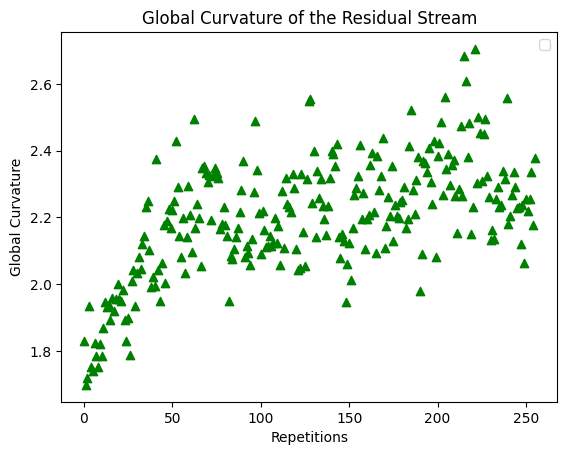

In [96]:
plot_curvature_vs_repetitions(results_dict, 0, offset=0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


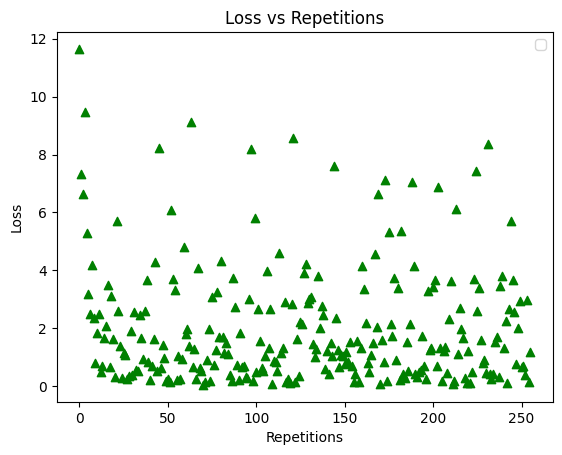

In [97]:
plot_loss_vs_repetitions(results_dict, 0, offset=0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


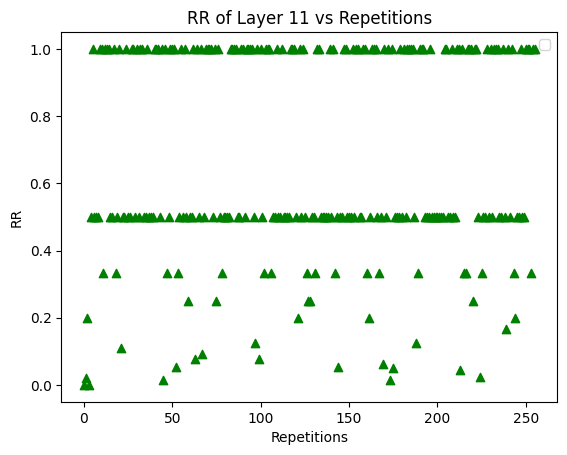

In [98]:
plot_rr_vs_repetitions(results_dict, 0, offset=0, layer=11)

# Plurals Regular Analysis

In [104]:
data = json.load(open("datasets/plurals_regular.json", "r"))

In [105]:
# Filter examples to only include one token inputs and targets
examples = []
for ex in data["examples"]:
  if len(model.to_tokens(" " + ex["input"])[0]) == 2 and len(model.to_tokens(" " + ex["target"])[0]) == 2:
    examples.append(ex)

In [106]:
import random
random.seed(1)
random.shuffle(examples)

In [107]:
data = " "
for example in examples:
  data += example["input"] + " : " + example["target"] + " "
  if len(data.split(" ")) == 1020:
    break

In [108]:
results = word_transformation_analysis(data, model)

In [109]:
# Just for consistency with repeat results, to reuse plotting scripts
results_dict = {}
results_dict[0] = results

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


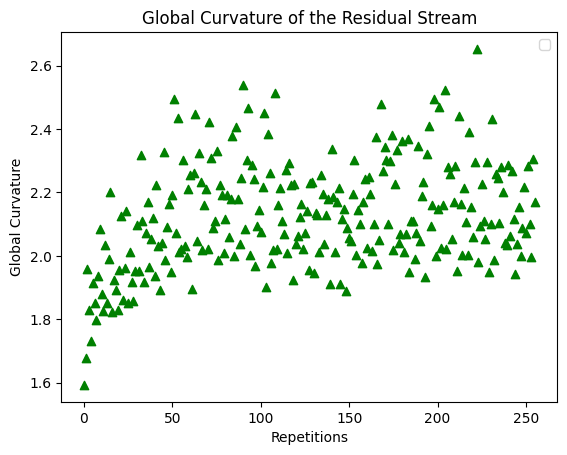

In [110]:
plot_curvature_vs_repetitions(results_dict, 0, offset=0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


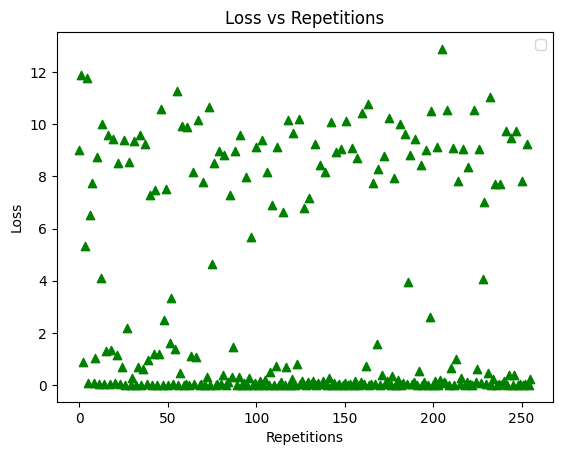

In [111]:
plot_loss_vs_repetitions(results_dict, 0, offset=0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


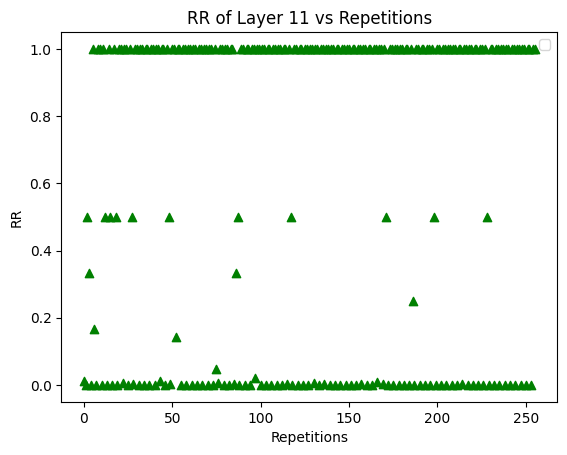

In [112]:
plot_rr_vs_repetitions(results_dict, 0, offset=0, layer=11)

# Denonym Experiment


In [114]:
import pandas as pd

eu = pd.read_csv("datasets/eu_countries_lang_and_people.csv")

countries = eu['Country'].to_list()
langs = eu["Languages"].to_list()
demonyms = eu["People"].to_list()

In [115]:
import random

same = []
diff = []
for i in range(len(countries)):
  c = countries[i]
  d = demonyms[i]
  lang = langs[i]
  if lang==d:
    same.append((c, d, lang))
  else:
    diff.append((c, d ,lang))


def nshot_switch(ns, idxs, switch_idx):
  assert ns>=2

  exs = []
  for i in idxs:
    exs.append(same[i])
  lang_prompt = ''
  demo_prompt = ''
  for ex in exs[:-1]:
    lang_prompt+=f"{ex[0]} : {ex[1]}\n"
    demo_prompt+=f"{ex[0]} : {ex[1]}\n"

  e = diff[switch_idx]
  pre_prompt = str(demo_prompt)+f"{e[0]} :"
  lang_prompt +=f'{e[0]} : {e[2]}\n'
  demo_prompt+=f'{e[0]} : {e[1]}\n'

  e = exs[-1]
  lang_prompt+=f"{e[0]} :"
  demo_prompt+=f'{e[0]} :'

  return pre_prompt, lang_prompt, demo_prompt

ns=6
idxs = np.random.choice(np.arange(len(same)), max(1, ns-1), replace=False)
switch_idx = random.choice(range(len(diff)))
a, b, c = nshot_switch(ns, idxs, switch_idx)
print(a)
print(b)
print(c)

lang_exs = [] #languages
demo_exs = [] #demonyms
highest_shot = len(same)
idxs = np.random.choice(np.arange(len(same)), max(1, highest_shot-1), replace=False)
switch_idx = random.choice(range(len(diff)))
for ns in range(2,highest_shot):
  my_idxs = idxs[:ns+1]
  p, l, d = nshot_switch(ns, my_idxs, switch_idx)

  lang_exs.append(l)
  demo_exs.append(d)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(lang_exs[0])
print(demo_exs[0])

Hungary : Hungarian
Former Yugoslav Republic of Macedonia : Macedonian
Greece : Greek
Moldova : Moldavian
Serbia :
Hungary : Hungarian
Former Yugoslav Republic of Macedonia : Macedonian
Greece : Greek
Moldova : Moldavian
Serbia : Serbian
Lithuania :
Hungary : Hungarian
Former Yugoslav Republic of Macedonia : Macedonian
Greece : Greek
Moldova : Moldavian
Serbia : Serb
Lithuania :
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Lithuania : Lithuanian
Portugal : Portuguese
Monaco : French
Romania :
Lithuania : Lithuanian
Portugal : Portuguese
Monaco : Monacan
Romania :


In [116]:
ex1 = "France : French\nItaly : Italian\nBelgium : Belgian"
ex1post=  "France : French\nItaly : Italian\nBelgium : Belgian\nSpain :"

ex_str_toks = model.to_str_tokens(ex1)
print(ex_str_toks)

prompts = []
#slightly simpler than using stream_idx for now but this is a todo

demo_mlp_curv = []
demo_attn_curv = []
demo_total_curv = []

lang_mlp_curv = []
lang_attn_curv = []
lang_total_curv = []

def run(pr):
  toks = model.to_tokens(pr)
  logits, cache = model.run_with_cache(toks, remove_batch_dim=True)
  return logits, cache

n_layers = model.cfg.n_layers
j = 0
for lprompt, dprompt in zip(lang_exs, demo_exs):
  print(j, "D prompt\n", dprompt)
  print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
  logits, cache = run(dprompt)
  curv = compute_global_curvature(cache, n_layers, -1)
  demo_total_curv.append(curv)
  curv = compute_global_curvature(cache, n_layers, -1, include_mlps=True, include_attn=False)
  demo_mlp_curv.append(curv)
  curv = compute_global_curvature(cache, n_layers, -1, include_mlps=False)
  demo_attn_curv.append(curv)

  logits, cache = run(lprompt)
  curv = compute_global_curvature(cache, n_layers, -1)
  lang_total_curv.append(curv)
  curv = compute_global_curvature(cache, n_layers, -1, include_mlps=True, include_attn=False)
  lang_mlp_curv.append(curv)
  curv = compute_global_curvature(cache, n_layers, -1, include_mlps=False)
  lang_attn_curv.append(curv)
  j+=1

ex1 = "France : French\nItaly : Italian\nBelgium :"
ex1post=  "France : French\nItaly : Italian\nBelgium : French\nSpain :"

['<|endoftext|>', 'France', ' :', ' French', '\n', 'Italy', ' :', ' Italian', '\n', 'Bel', 'g', 'ium', ' :', ' Belgian']
0 D prompt
 Lithuania : Lithuanian
Portugal : Portuguese
Monaco : Monacan
Romania :
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


TypeError: compute_global_curvature() missing 1 required positional argument: 'sequence_length'

In [ ]:
plt.xticks(range(len(demo_attn_curv)))
plt.plot(demo_attn_curv, label='Demonym Attention', color='red', marker='o')
plt.plot(demo_mlp_curv, label='Demonym MLPs', color='blue', marker='o')
plt.plot(demo_total_curv, label='Demonym total', color='gold', marker='o')


plt.plot(lang_attn_curv, label='Language Attention', color='darkred', marker='v')
plt.plot(lang_mlp_curv, label='Language MLPs', color='darkblue', marker='v')
plt.plot(lang_total_curv, label='Demonym total', color='gold', marker='v')

plt.legend()

# Other stuff

In [113]:
x = list(range(len(dataset_curvatures)))
y = dataset_curvatures

print(len(x))
print(len(y))
plt.scatter(x, y, c="green", marker="^", label='Full Model')

y = dataset_mlp_curvatures
plt.scatter(x, y, c="blue", marker="o", label='MLPs')

y = dataset_attn_curvatures
plt.scatter(x, y, c="red", marker="v", label='Attns')
#plt.xticks(x)
plt.xticks(np.arange(0, 375, 25))
plt.legend()
plt.title("Global Curvature of the Residual Stream: "+str(num_reps)+" Repetitions")
plt.ylabel("Global Curvature")
plt.xlabel("Repetitions")
plt.show()

NameError: name 'dataset_curvatures' is not defined

In [ ]:
dataset_mlp_curvatures[340:343] #341 is where it flatlines in both. Each repetition is 3 tokens, 341*3=1023, the seq_len of gpt2

[array(1.0373223, dtype=float32),
 array(1.0245275, dtype=float32),
 array(1.0245275, dtype=float32)]

In [ ]:
wpe_norms = []
print(model.W_pos.shape)
for p in model.W_pos: #I know this is not the right way to do this but oh well
  wpe_norms.append(torch.linalg.norm(p).cpu().numpy())

torch.Size([1024, 1024])


5.178125 1024


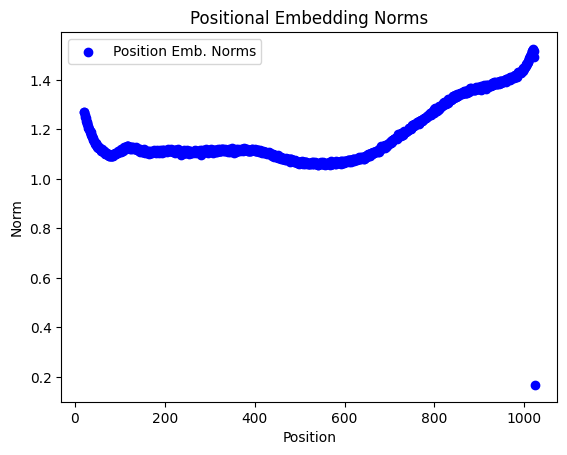

In [ ]:
print(wpe_norms[0], len(wpe_norms))
plt.scatter(np.arange(1024)[20:], wpe_norms[20:], c="blue", marker="o", label='Position Emb. Norms')

plt.legend()
plt.title("Positional Embedding Norms")
plt.ylabel("Norm")
plt.xlabel("Position")
plt.show()

In [ ]:
def cossim(x, y):
  return torch.dot(x,y)/(torch.linalg.norm(x)*torch.linalg.norm(y))

c = []
for i in range(1, len(model.W_pos)):
  c.append(cossim(model.W_pos[i], model.W_pos[0]).cpu())


Text(0.5, 1.0, 'Cos Similarity between each Positional embedding and pos_emb[0]')

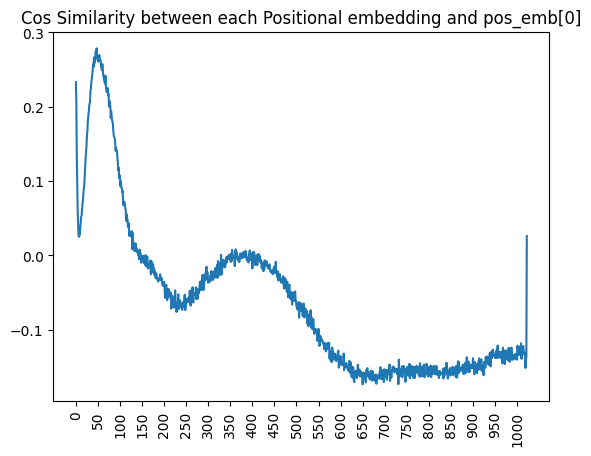

In [ ]:
plt.plot(c)
plt.xticks(np.arange(0,1024,50), rotation=90)
plt.title("Cos Similarity between each Positional embedding and pos_emb[0]")

In [ ]:
wpe_norms[48:53]

[array(3.385507, dtype=float32),
 array(3.3844604, dtype=float32),
 array(3.3833342, dtype=float32),
 array(3.378088, dtype=float32),
 array(3.3710709, dtype=float32)]

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

4189

In [ ]:
dataset_losses = []
ds = datasets[-1]
for prompt in ds:
  gpt2_tokens = model.to_tokens(prompt)
  print(gpt2_tokens)
  gpt2_logits = model(gpt2_tokens)
  correct_log_probs = model.loss_fn(gpt2_logits, gpt2_tokens, per_token=True)
  dataset_losses.append(correct_log_probs[0].cpu())

tensor([[50256,   257,   275,  ...,   257,   275,   269]], device='cuda:0')


341


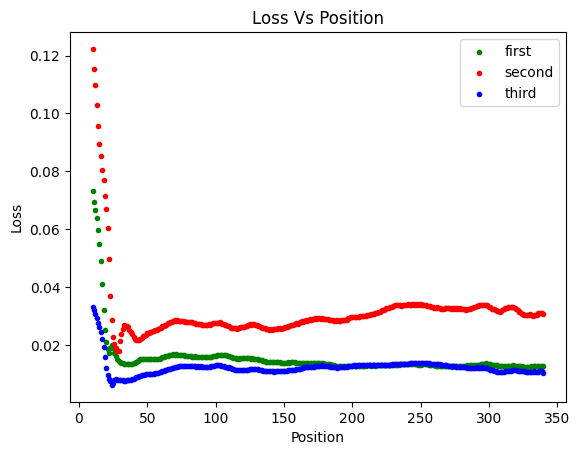

In [ ]:
y = dataset_losses[0]
first = y[0::3]
second = y[1::3]
third = y[2::3]
x = range(len(first))

print(len(x))
#print(len(fifth))
plt.scatter(x[10:], first[10:], c="green", marker=".", label="first")
plt.scatter(x[10:], second[10:], c="red", marker=".", label="second")
plt.scatter(x[10:], third[10:], c="blue", marker=".", label="third")
plt.legend()
plt.title("Loss Vs Position")
plt.ylabel("Loss")
plt.xlabel("Position")
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2916: UserWarning:

reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.



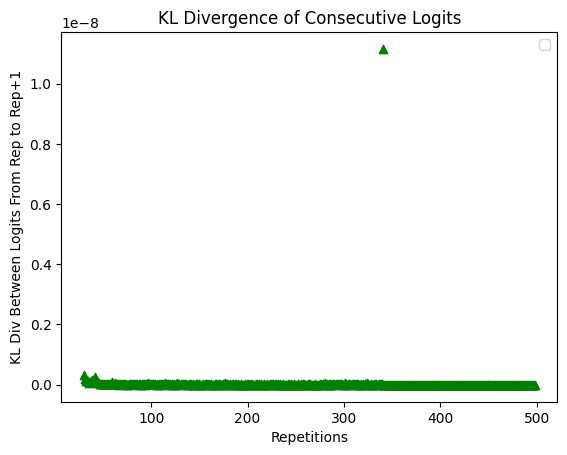

In [ ]:
kls = compute_prob_kls(dataset_probs)

x = list(range(len(kls)))
y = kls

plt.scatter(x[30:], y[30:], c="green", marker="^")

plt.legend()
plt.title("KL Divergence of Consecutive Logits")
plt.ylabel("KL Div Between Logits From Rep to Rep+1")
plt.xlabel("Repetitions")
plt.show()

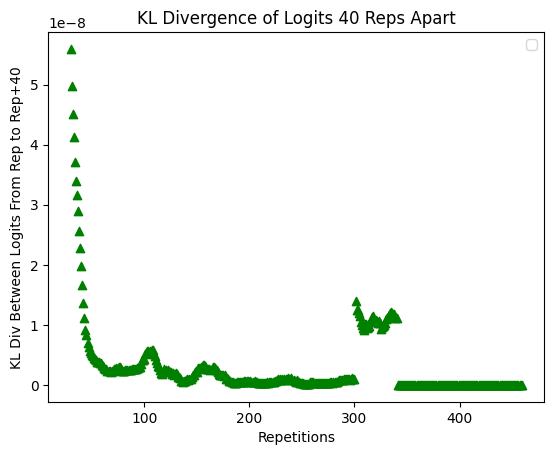

In [ ]:
kls = compute_long_range_kls(dataset_probs)

x = list(range(len(kls)))
y = kls

plt.scatter(x[30:], y[30:], c="green", marker="^")

plt.legend()
plt.title("KL Divergence of Logits 40 Reps Apart")
plt.ylabel("KL Div Between Logits From Rep to Rep+40")
plt.xlabel("Repetitions")
plt.show()

200
200


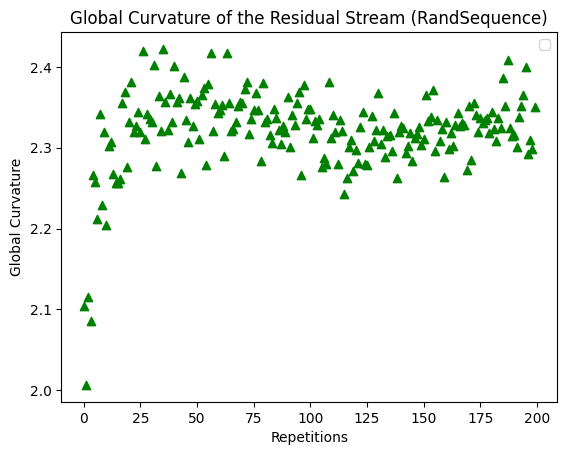

In [ ]:
x = []
y = []
for i in range(200):
  x += [i]
  y += dataset_curvatures[i]

print(len(x))
print(len(y))
plt.scatter(x, y, c="green", marker="^")

plt.legend()
plt.title("Global Curvature of the Residual Stream (RandSequence)")
plt.ylabel("Global Curvature")
plt.xlabel("Repetitions")
plt.show()